## 项目介绍

巴西最大的汽车和房主保险公司之一的 Porto Seguro 需要通过更有效的手段对索赔预测，在本次比赛中，所面临的挑战是建立一个模型来预测驾驶员在明年提出汽车保险索赔的概率。虽然 Porto Seguro 过去 20 年来一直使用机器学习，但他们希望 Kaggle 的机器学习社区能够探索新的、更强大的方法。更准确的预测将使他们能够进一步调整价格，并有望使更多司机更容易获得汽车保险。提出索赔的概率根据很多不同协变量影响，数据科学家需要根据每一个客户的风险类型定制保险配置以及价格，所以要预测用户提出索赔的概率，也就是每一个用户风险高低程度。（文本译自Kaggle英文项目介绍）

项目原链接：https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction

## 项目目的

**客户层面**
   * 为用户提供适合自身风险程度的配置方案，让司机更容易获取适合自身条件的汽车保险方案，得到更多的自身保护利益。   
 
**保险公司层面**
   * 为用户提供更好的配置方案，提升用户的投保意愿，从而提升公司利润于增长。
   * 特征选取/特征工程有利于缩减公司对于每一个用户那些对于风险预测贡献度低的特征的研究成本，对于对模型建立贡献度高的模型，将研究成本投入到这些特征中去，不断迭代反哺，使得这个模型更多能集中于这些高贡献度的特征中进行挖掘，节约研究和人力成本。
   * 将挖掘信息特征的过程代码化、体系化、规范化，构建data pipeline，提升公司效率。

## 模型评估指标

Normalized Gini Coefficient

## 模块、包、及库的导入

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [187]:
pip install category_encoders

     |████████████████████████████████| 81 kB 6.1 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [194]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from sklearn.utils import shuffle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from datetime import timedelta, datetime
from xgboost import XGBClassifier
from xgboost import plot_importance
from category_encoders.target_encoder import TargetEncoder

## 数据导入

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 数据检查及元数据分析

In [6]:
#查看训练集的维度
train.shape

(595212, 59)

In [7]:
#查看测试集的维度
test.shape

(892816, 58)

In [8]:
#查看训练集信息
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 59 entries, id to ps_calc_20_bin
dtypes: float64(10), int64(49)
memory usage: 267.9 MB


In [9]:
#查看测试集信息
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Columns: 58 entries, id to ps_calc_20_bin
dtypes: float64(10), int64(48)
memory usage: 395.1 MB


In [10]:
#查看训练集前5行
train.head()

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0              0              0              1              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              0              1              0              0  ...   
4              0              1              0              0  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1           1           9               0   
2           4           2           7           7               0   
3           2           2           4           9               0   
4           3           1           1           3               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               1               1               0               1   
2               1               1               0               1   
3               0               0               0               0   
4               0               0               1               1   

   ps_calc_20_bin  
0               1  
1               0  
2               0  
3               0  
4               0  

[5 rows x 59 columns]

In [11]:
#查看测试集前5行
test.head()

id  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  \
0   0          0              1          8              1              0   
1   1          4              2          5              1              0   
2   2          5              1          3              0              0   
3   3          0              1          6              0              0   
4   4          5              1          7              0              0   

   ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  ...  \
0              0              1              0              0  ...   
1              0              0              0              1  ...   
2              0              0              0              1  ...   
3              1              0              0              0  ...   
4              0              0              0              1  ...   

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           1           1           1          12               0   
1           2           0           3          10               0   
2           4           0           2           4               0   
3           5           1           0           5               1   
4           4           0           0           4               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               0               1               1               0   
2               0               0               0               0   
3               0               1               0               0   
4               1               1               0               0   

   ps_calc_20_bin  
0               1  
1               1  
2               0  
3               0  
4               1  

[5 rows x 58 columns]

In [12]:
#定义对训练集和测试集数据的每一个维度进行梳理分析的元数据表格建立函数
def meta(train, test, missing_values = -1, cols_ignore_missing = []):
    df = pd.concat([train,test]).reset_index(drop=True).fillna('unknown')
    
    data = []
    
    for col in df.columns:
        
        #定义 role - 将每一列分为序号、标签、特征三种
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
            
        #定义 category - 将每一列分为个人，汽车，地域， 计算后， 其他五种
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else: 
            category = 'other'
            
        #定义 level of measurement - 将每一列分为binary, nominal, interval, ratio, ordinal五种
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values, np.nan).max() - df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values, np.nan).max() - df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        #定义 data type
        dtype = df[col].dtype
        
        #定义 unique - 计算每一列的unique value的个数，id以及浮点数除外
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
        
        #定义 cardinality - 根据每一列unique value的个数将他们分为low, medium, high, ignore四种
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low'
        elif uniq <= 39:
            cardinality = 'Medium'
        else:
            cardinality = 'High'
        
        #定义 missing - 计算每一列missing的个数
        if col in cols_ignore_missing:
            missing = 0;
        else:
            missing = sum(df[col] == missing_values)
        
        #定义 missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        #定义 imputation - 根据数据类别以及缺失值占比制定缺失值填充策略
        if missing > df.shape[0] * 0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode', 'median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode', 'median', 'mean')
        else:
            imputation = 'No Missing'

        #定义 keep - 去除imputation说明要去除的列以及id列
        keep = True
        if col == 'id' or imputation == 'remove':
            keep = False
          
        #整合每一列的元数据字典并插入到元数据列表中
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    
    #将元数据列表转为pandas DataFrame
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [13]:
#制作本数据集的meta data表格
metadata = meta(train, test)
metadata

role    category     level    dtype cardinality  \
colname                                                              
id                   id       other   nominal    int64      Ignore   
target           target       other    binary   object           3   
ps_ind_01       feature  individual   ordinal    int64           8   
ps_ind_02_cat   feature  individual   nominal    int64           4   
ps_ind_03       feature  individual   ordinal    int64          12   
ps_ind_04_cat   feature  individual   nominal    int64           2   
ps_ind_05_cat   feature  individual   nominal    int64           7   
ps_ind_06_bin   feature  individual    binary    int64           2   
ps_ind_07_bin   feature  individual    binary    int64           2   
ps_ind_08_bin   feature  individual    binary    int64           2   
ps_ind_09_bin   feature  individual    binary    int64           2   
ps_ind_10_bin   feature  individual    binary    int64           2   
ps_ind_11_bin   feature  individual    binary    int64           2   
ps_ind_12_bin   feature  individual    binary    int64           2   
ps_ind_13_bin   feature  individual    binary    int64           2   
ps_ind_14       feature  individual   ordinal    int64           5   
ps_ind_15       feature  individual   ordinal    int64          14   
ps_ind_16_bin   feature  individual    binary    int64           2   
ps_ind_17_bin   feature  individual    binary    int64           2   
ps_ind_18_bin   feature  individual    binary    int64           2   
ps_reg_01       feature      region     ratio  float64      Ignore   
ps_reg_02       feature      region  interval  float64      Ignore   
ps_reg_03       feature      region  interval  float64      Ignore   
ps_car_01_cat   feature         car   nominal    int64          12   
ps_car_02_cat   feature         car   nominal    int64           2   
ps_car_03_cat   feature         car   nominal    int64           2   
ps_car_04_cat   feature         car   nominal    int64          10   
ps_car_05_cat   feature         car   nominal    int64           2   
ps_car_06_cat   feature         car   nominal    int64          18   
ps_car_07_cat   feature         car   nominal    int64           2   
ps_car_08_cat   feature         car   nominal    int64           2   
ps_car_09_cat   feature         car   nominal    int64           5   
ps_car_10_cat   feature         car   nominal    int64           3   
ps_car_11_cat   feature         car   nominal    int64         104   
ps_car_11       feature         car   ordinal    int64           4   
ps_car_12       feature         car  interval  float64      Ignore   
ps_car_13       feature         car  interval  float64      Ignore   
ps_car_14       feature         car     ratio  float64      Ignore   
ps_car_15       feature         car  interval  float64      Ignore   
ps_calc_01      feature  calculated     ratio  float64      Ignore   
ps_calc_02      feature  calculated     ratio  float64      Ignore   
ps_calc_03      feature  calculated     ratio  float64      Ignore   
ps_calc_04      feature  calculated   ordinal    int64           6   
ps_calc_05      feature  calculated   ordinal    int64           7   
ps_calc_06      feature  calculated   ordinal    int64          11   
ps_calc_07      feature  calculated   ordinal    int64          10   
ps_calc_08      feature  calculated   ordinal    int64          12   
ps_calc_09      feature  calculated   ordinal    int64           8   
ps_calc_10      feature  calculated   ordinal    int64          26   
ps_calc_11      feature  calculated   ordinal    int64          21   
ps_calc_12      feature  calculated   ordinal    int64          12   
ps_calc_13      feature  calculated   ordinal    int64          16   
ps_calc_14      feature  calculated   ordinal    int64          25   
ps_calc_15_bin  feature  calculated    binary    int64           2   
ps_calc_16_bin  feature  calculated    binary    int64           2   
ps_calc_17_bin  feature  calc

In [14]:
#查看每一个数据role和变量类型level各具有多少特征
metadata.groupby(['role','level']).size().reset_index(name = 'count')

role     level  count
0  feature    binary     17
1  feature  interval      5
2  feature   nominal     14
3  feature   ordinal     16
4  feature     ratio      5
5       id   nominal      1
6   target    binary      1

In [15]:
#对连续性变量（此处为浮点数）进行统计描述性分析
fullset = pd.concat([train,test],ignore_index=True)
stats = fullset[metadata[metadata.dtype == 'float64'].index].describe()
stats

ps_reg_01     ps_reg_02     ps_reg_03     ps_car_12     ps_car_13  \
count  1.488028e+06  1.488028e+06  1.488028e+06  1.488028e+06  1.488028e+06   
mean   6.110305e-01  4.395943e-01  5.514848e-01  3.799519e-01  8.134878e-01   
std    2.876763e-01  4.045123e-01  7.938159e-01  5.836187e-02  2.247024e-01   
min    0.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00  2.506191e-01   
25%    4.000000e-01  2.000000e-01  5.250000e-01  3.162278e-01  6.710052e-01   
50%    7.000000e-01  3.000000e-01  7.211103e-01  3.741657e-01  7.660406e-01   
75%    9.000000e-01  6.000000e-01  1.001561e+00  4.000000e-01  9.061429e-01   
max    9.000000e-01  1.800000e+00  4.423517e+00  1.264911e+00  4.031301e+00   

          ps_car_14     ps_car_15    ps_calc_01    ps_calc_02    ps_calc_03  
count  1.488028e+06  1.488028e+06  1.488028e+06  1.488028e+06  1.488028e+06  
mean   2.763614e-01  3.067355e+00  4.496817e-01  4.501073e-01  4.499718e-01  
std    3.569623e-01  7.299510e-01  2.872071e-01  2.871817e-01  2.872136e-01  
min   -1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%    3.339162e-01  2.828427e+00  2.000000e-01  2.000000e-01  2.000000e-01  
50%    3.687818e-01  3.316625e+00  4.000000e-01  5.000000e-01  5.000000e-01  
75%    3.964846e-01  3.605551e+00  7.000000e-01  7.000000e-01  7.000000e-01  
max    6.363961e-01  3.741657e+00  9.000000e-01  9.000000e-01  9.000000e-01

<AxesSubplot:>

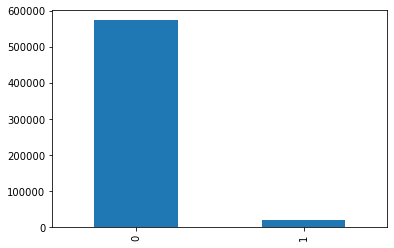

In [16]:
#查看训练集不同标签的个数
train.target.value_counts().plot(kind='bar')

In [17]:
train.target.value_counts(normalize=True).mul(100)

0    96.355248
1     3.644752
Name: target, dtype: float64

在训练集数据中，观察到标签为0的数据占大多数。由此我们可以得知发起索赔的用户占比比较少，对于这种类别占比极度不平衡的数据集。如果这种情况下使用分类准确度ACC这种传统指标来评估分类器，那么分类器会依赖输出多数类获得更高的分类准确率，但在我们所关注的少数类中表现不佳。

### 重点总结 Key Takeaway

* 数据集种类占比极度不平衡，在处理数据与建立模型时应着重考虑这一点。
* 数据维度一共有57个维度，数据维度较高，后续可观察情况进行特征池规模的缩减。
* 数据集中每个维度的数据类型只有int64以及float64两种，说明公司为了保护客户信息安全，在公开数据集前的其他文本数据已被转换为整数。
* 同样为了保护客户信息安全，公司未将特征的信息及具体含义公开，所以做特称处理时我们并不能使用特征的名称来判断此特征对预测是否有效，只能通过变量类型，拆解整合来探索特征间和特征与预测结果间的联系。

## 不平衡类别数据处理

此处数据类别不平衡的情况十分明显，大约96%的数据对应的target标签是“不索赔”，而4%的数据对应的标签是“索赔”。我们需要预测用户索赔的情况，那么我们更希望模型从4%的数据中去挖掘索赔人群的特征，因此我们选用undersampling的方法进行重取样。

我们将使用下列公式计算undersampling rate
$undersampling\hspace{0.1cm}rate = \frac{(1-r)\hspace{0.1cm}\times \hspace{0.1cm}minority\hspace{0.1cm}size}{r\hspace{0.1cm}\times \hspace{0.1cm}majority\hspace{0.1cm}size}\hspace{0.1cm}where\hspace{0.1cm}r\hspace{0.1cm}=\hspace{0.1cm}desired\hspace{0.1cm}proportion$

In [18]:
#定义欠采样函数
def undersampling(df, desired_prop_rate = 0.15):
    
    #获取target标签为0或1的index
    idx_target_0 = df.query('target == 0').index
    idx_target_1 = df.query('target == 1').index
    
    #获取target标签为0或1的数据个数
    cnt_target_0 = df.target.value_counts()[0]
    cnt_target_1 = df.target.value_counts()[1]
    
    #根据公式计算undersampling rate
    undersampling_rate = (cnt_target_1 * (1 - desired_prop_rate))/(desired_prop_rate * cnt_target_0)
    undersampled_majority_size = round(undersampling_rate * cnt_target_0)
    print(f'关于target=0的欠采样比率为：{round(undersampling_rate,2)}')
    print(f'欠采样后target=0的数据数量为：{undersampled_majority_size}')
    
    #使用sklearn的shuffle函数对target=0的数据的index进行打乱抽样，seed=100
    undersampled_idx = shuffle(idx_target_0, n_samples = undersampled_majority_size, random_state=100)
    
    #将欠采样后的index和先前target=1的index合并
    idx_all = idx_target_1.union(undersampled_idx)
    
    #在训练集中用index将处理后数据的index吧数据索引出来
    df = df.loc[idx_all].reset_index(drop=True)
    
    return df

In [19]:
#使用欠取样函数处理训练集并将结果储存到新的csv文件中
#undersampling(df=train).to_csv('train_balanced.csv')

In [20]:
train_balanced = pd.read_csv('train_balanced.csv', index_col=0)

In [21]:
#将训练集和测试集整合为全集
fullset_update = pd.concat([train_balanced,test], ignore_index=True)
fullset_update_cp = fullset_update.copy()

## 缺失值处理

In [22]:
metadata = meta(train_balanced, test)

In [23]:
#用更新的元数据表格查看带有缺失值的特征
missing_data = metadata[['level','missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by='missing', ascending=False)
missing_data

level  missing missing_percent            imputation
colname                                                               
ps_car_03_cat   nominal   715371  715371(68.96%)                remove
ps_car_05_cat   nominal   464241  464241(44.75%)                remove
ps_reg_03      interval   186910  186910(18.02%)  (mode, median, mean)
ps_car_14         ratio    74374    74374(7.17%)  (mode, median, mean)
ps_car_07_cat   nominal    20480    20480(1.97%)                  mode
ps_ind_05_cat   nominal    10314    10314(0.99%)                  mode
ps_car_09_cat   nominal     1042      1042(0.1%)                  mode
ps_ind_02_cat   nominal      387      387(0.04%)                  mode
ps_car_01_cat   nominal      213      213(0.02%)                  mode
ps_ind_04_cat   nominal      193      193(0.02%)                  mode
ps_car_02_cat   nominal        5         5(0.0%)                  mode
ps_car_11       ordinal        2         2(0.0%)        (mode, median)

对于带有缺失值的变量，我们将采取以下尝试，再看运行效果进行修改：
* 对于数据缺失率大于40%的变量将作去除处理
* 对于缺失值关联程度高的变量以及连续型的变量将进行多变量填充
* 对于其他变量，我们将采取metadata函数返回的imputation方法来填充

In [24]:
#找出需要去除的变量
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()

In [25]:
#找出需要填充的变量
cols_to_imp = missing_data.index[2:].to_list()

#根据元数据结果imputation的方法查找属于不同填充方法的变量
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode','median','mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode','median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

<AxesSubplot:>

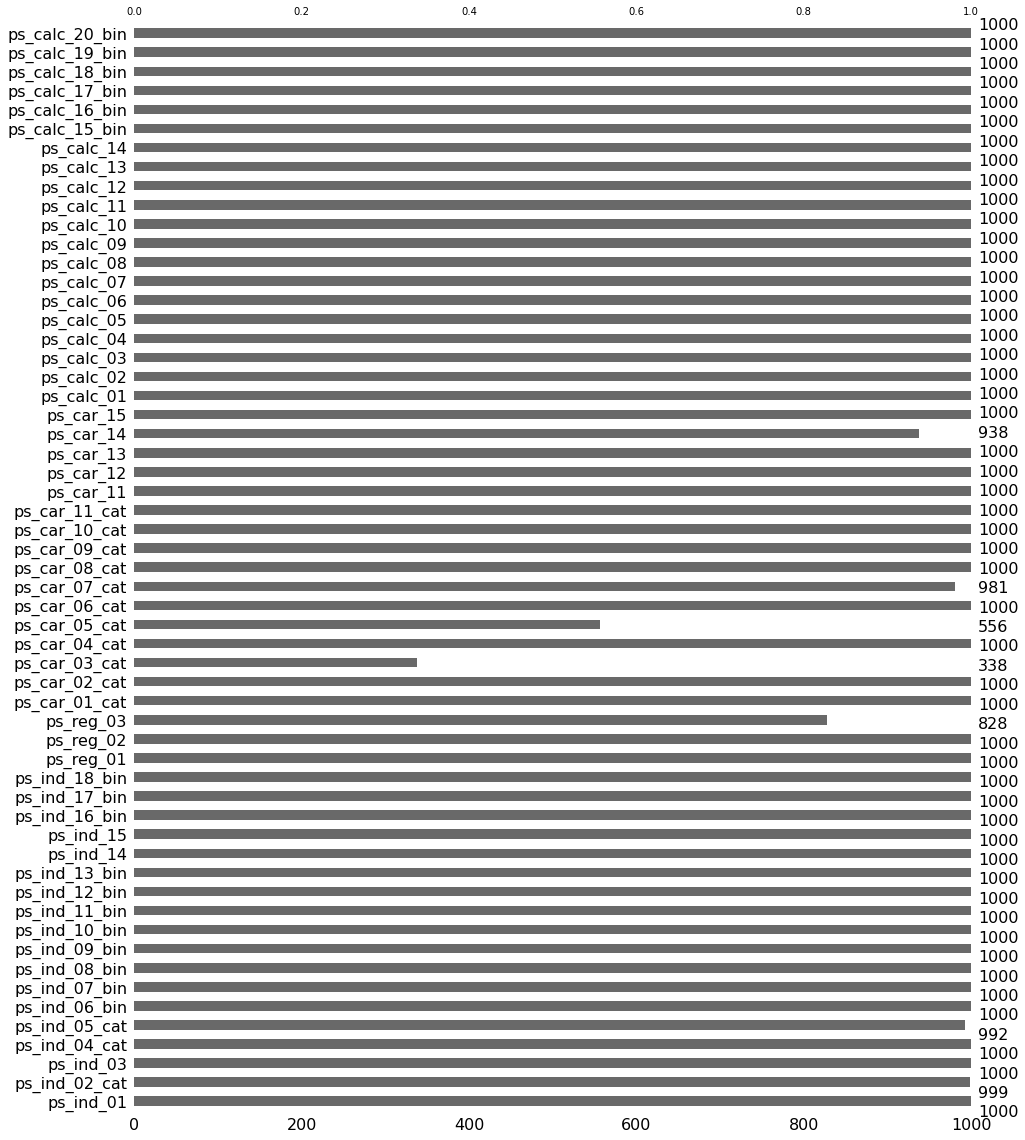

In [26]:
#查看fullset中缺失值的占比
msno.bar(fullset_update.drop(['id','target'], axis=1).replace(-1,np.nan).sample(1000), figsize=(15,20))

<AxesSubplot:>

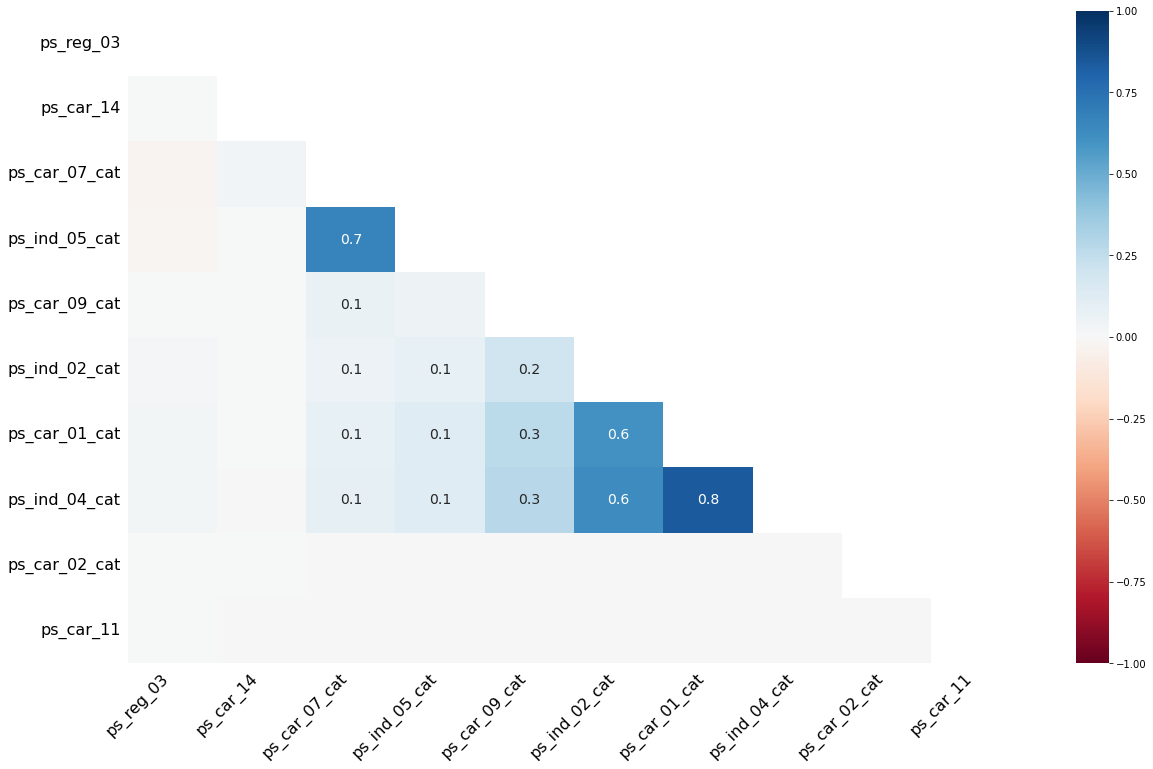

In [27]:
#用Heatmap查看NA值出现机率的相关性（missingno文档中将其称为无效相关性Nullity Correlation）
#heatmap方便观察两个变量间的相关性，但是当数据集变大，这种结论的解释性会变差
msno.heatmap(fullset_update[cols_to_imp].replace(-1,np.nan))

<AxesSubplot:>

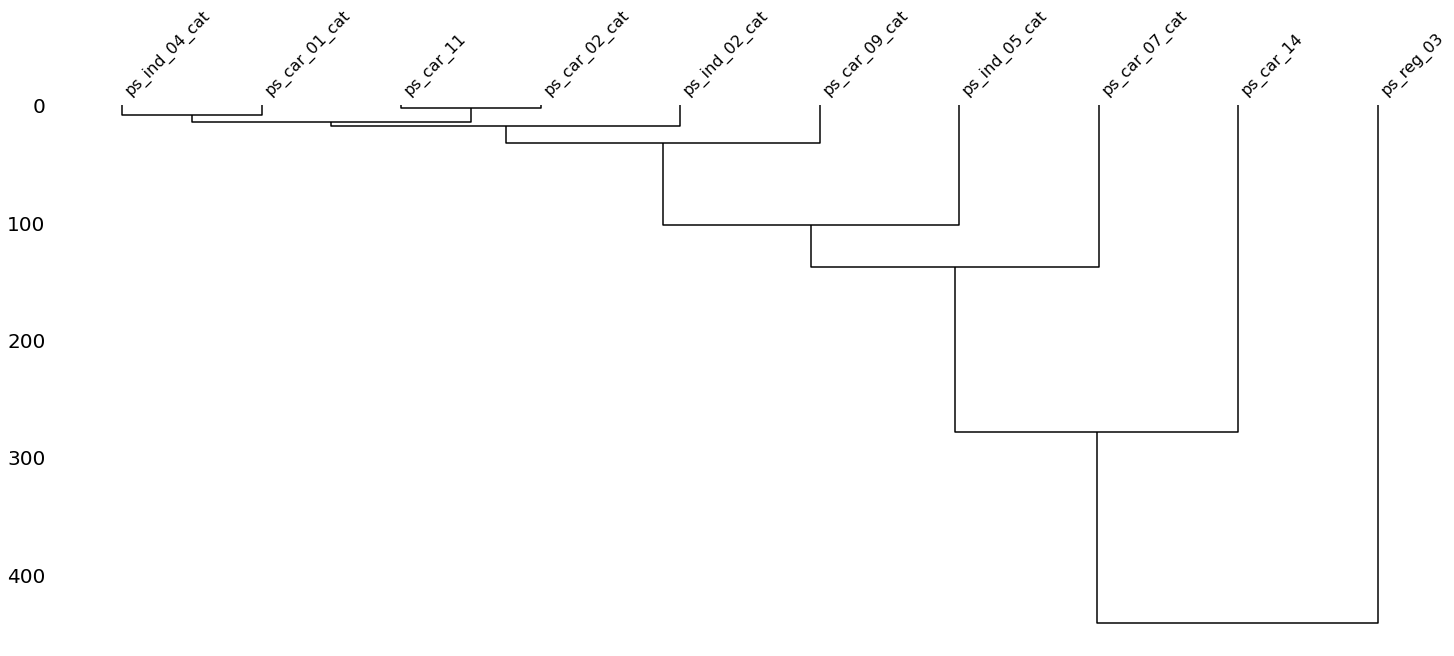

In [28]:
#用Dendrogram查看按照NA值绘制的各列的树枝状图
#The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap
#
msno.dendrogram(fullset_update[cols_to_imp].replace(-1,np.nan))

从dendrogram以及heapmap的结果我们可以看出一下变量之间的缺失值关联程度比较大：
* ps_ind_05_cat 和 ps_car_07_cat
* ps_car_01_cat 和 ps_ind_02_cat 和 ps_ind_04_cat

### 多变量填充
那么根据我们的策略，我们将尝试对一下缺失值关联程度较高的变量和连续性变量进行多变量填充： 
* ps_ind_05_cat 和 ps_car_07_cat（缺失值关联性高）
* ps_car_01_cat 和 ps_ind_02_cat 和 ps_ind_04_cat（缺失值关联性高）
* ps_reg_03 和 ps_car_14（连续型变量）

In [29]:
#将待填充的变量分离出来
set1 = ['ps_ind_05_cat', 'ps_car_07_cat']
set2 = ['ps_car_01_cat', 'ps_ind_02_cat', 'ps_ind_04_cat']
set3 = ['ps_reg_03', 'ps_car_14']

In [30]:
#Multivariate Imputation By Chained Equations (MICE)
rf = RandomForestRegressor(n_estimators=10, random_state=123)
imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)

In [31]:
%%time
#尝试用MICE来填充set1
set1_imp = imp_mean.fit_transform(fullset_update_cp[set1])
set1_df = pd.DataFrame(set1_imp, columns=set1)

CPU times: user 4.53 s, sys: 391 ms, total: 4.92 s
Wall time: 4.93 s


In [32]:
set1_df['ps_ind_05_cat'].value_counts()

0.000000    918529
6.000000     36578
4.000000     32096
3.000000     14616
1.000000     14573
0.426078     10305
2.000000      7652
5.000000      3085
0.413663         9
Name: ps_ind_05_cat, dtype: int64

如果观察多几行数据，我们可以发现mice在填充nominal类型的变量的时候，把整数的类别填充成小数了。这对数据类型产生变动，所以我们需要将小数round成整数。如果将这些填充好的小数直接round，出来就和用单变量填充没有什么区别，那么我们将改为用众数填充。

In [33]:
%%time
#尝试用MICE来填充set2
set2_imp = imp_mean.fit_transform(fullset_update_cp[set2])
set2_df = pd.DataFrame(set2_imp, columns=set2)

CPU times: user 20.9 s, sys: 473 ms, total: 21.4 s
Wall time: 21.4 s


我们可以观察到，我们set2中有三个变量时，我们的运行时间就指数型增加了，接近23秒的运行时间证明这个算法十分expensive。而且我们利用metadata观察到这三列数据中在几十列的数据中只有几百个缺失值，所以我们并不值得用这么多时间去填充数据，因此我们改用单片量填充中的众数填充方法。

In [34]:
%%time
#尝试用MICE来填充set3 train
set3_imp = imp_mean.fit_transform(fullset_update_cp[set3])
set3_df = pd.DataFrame(set3_imp, columns=set3)

CPU times: user 1min 14s, sys: 437 ms, total: 1min 15s
Wall time: 1min 15s


我们观察到运行时间比较长，我们现在来观察一下这一组连续型变量的分布，看看这组变量是否适合使用这种方法来填充。

In [35]:
set3_df

ps_reg_03  ps_car_14
0         0.718070   0.370810
1         0.617454   0.368782
2         2.316652   0.390256
3         0.684197   0.356090
4         0.911765   0.532917
...            ...        ...
1037438   1.048809   0.565685
1037439   1.246495   0.418569
1037440   0.609303   0.390384
1037441   0.920937   0.378153
1037442   0.992157   0.296648

[1037443 rows x 2 columns]

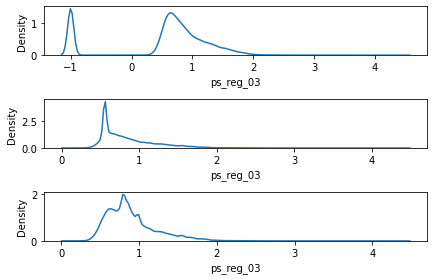

In [36]:
#利用核密度估计kernel density estimation查看概率论中用来估计未知的密度函数以直观地看出数据样本本身的分布特征

#ps_reg_03分布

#原本的数据分布
plt.subplot(3,1,1)
sns.kdeplot(fullset_update_cp[set3[0]])

#用均值填充缺失值后的数据分布
plt.subplot(3,1,2)
sns.kdeplot(fullset_update_cp[set3[0]].replace(-1, np.nan).fillna(fullset_update_cp[set3[0]].mean()))

#用MICE填充迭代后的数据分布
plt.subplot(3,1,3)
sns.kdeplot(set3_df[set3[0]])

plt.tight_layout()

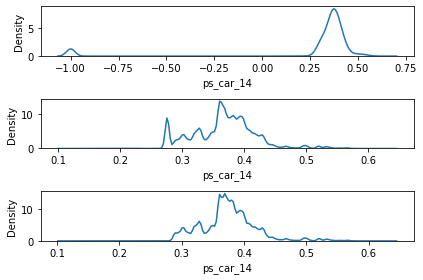

In [37]:
#ps_car_14分布

#原本的数据分布
plt.subplot(3,1,1)
sns.kdeplot(fullset_update_cp[set3[1]])

#用均值填充缺失值后的数据分布
plt.subplot(3,1,2)
sns.kdeplot(fullset_update_cp[set3[1]].replace(-1, np.nan).fillna(fullset_update_cp[set3[1]].mean()))

#用MICE填充迭代后的数据分布
plt.subplot(3,1,3)
sns.kdeplot(set3_df[set3[1]])

plt.tight_layout()

观察我们的分布图我们可以看到，用均值填充缺失值和迭代过后的数据概率分布十分相似，那么我们可以选择用MICE填充set3的两列数据。

In [38]:
#将用MICE多变量填充set3 train的结果保存到train集中
fullset_update_cp[set3] = pd.DataFrame(set3_imp,columns = set3)

### 单变量填充

那么根据我们的策略，我们将尝试对一下除了一下数据以外的其他数据进行单变量填充：

* ps_reg_03 和 ps_car_14（已经用多变量填充了）
* ps_car_03_cat	和 ps_car_05_cat（缺失值太多需要drop）

In [39]:
#查看剩下需要单变量填充的数据
missing_data[4:]

level  missing missing_percent      imputation
colname                                                        
ps_car_07_cat  nominal    20480    20480(1.97%)            mode
ps_ind_05_cat  nominal    10314    10314(0.99%)            mode
ps_car_09_cat  nominal     1042      1042(0.1%)            mode
ps_ind_02_cat  nominal      387      387(0.04%)            mode
ps_car_01_cat  nominal      213      213(0.02%)            mode
ps_ind_04_cat  nominal      193      193(0.02%)            mode
ps_car_02_cat  nominal        5         5(0.0%)            mode
ps_car_11      ordinal        2         2(0.0%)  (mode, median)

我们观察可以发现，nominal，那么我们都可以用mode众数来填充数据。最后两列ps_car_11和ps_car_12可以有两到三种的选择，但是这里几十万条数据中我们只有个位数的缺失值，选择用哪一种方法其实差别并不会很大。所以方便起见，我们可以将所有一并放在一起用众数填充。

In [40]:
mode_imputer = SimpleImputer(missing_values=-1, strategy='most_frequent', add_indicator=True)
imp = mode_imputer.fit_transform(fullset_update_cp[missing_data[4:].index])

In [41]:
fullset_update_cp[missing_data[4:].index] = pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

fullset_update_cp[missing_data[4:].index] = fullset_update_cp[missing_data[4:].index].astype('int64')

### 去除部分变量

那么根据我们的策略，我们已经对单变量和多变量填充的步骤完成了，我们现在将数据缺失率大于40%的变量去除：
* ps_car_03_cat	
* ps_car_05_cat

In [42]:
#去除变量
fullset_update_cp.drop(cols_to_drop, axis=1, inplace=True)

In [43]:
#检查我们是否仍有缺失值
print("missing value count in fullset: {}".format((fullset_update_cp==-1).sum().sum()))

missing value count in fullset: 0


## EDA探索式数据分析

In [44]:
#查看先前创建关于原数据集的metadata表格
metadata

role    category     level    dtype cardinality  \
colname                                                              
id                   id       other   nominal    int64      Ignore   
target           target       other    binary   object           3   
ps_ind_01       feature  individual   ordinal    int64           8   
ps_ind_02_cat   feature  individual   nominal    int64           4   
ps_ind_03       feature  individual   ordinal    int64          12   
ps_ind_04_cat   feature  individual   nominal    int64           2   
ps_ind_05_cat   feature  individual   nominal    int64           7   
ps_ind_06_bin   feature  individual    binary    int64           2   
ps_ind_07_bin   feature  individual    binary    int64           2   
ps_ind_08_bin   feature  individual    binary    int64           2   
ps_ind_09_bin   feature  individual    binary    int64           2   
ps_ind_10_bin   feature  individual    binary    int64           2   
ps_ind_11_bin   feature  individual    binary    int64           2   
ps_ind_12_bin   feature  individual    binary    int64           2   
ps_ind_13_bin   feature  individual    binary    int64           2   
ps_ind_14       feature  individual   ordinal    int64           5   
ps_ind_15       feature  individual   ordinal    int64          14   
ps_ind_16_bin   feature  individual    binary    int64           2   
ps_ind_17_bin   feature  individual    binary    int64           2   
ps_ind_18_bin   feature  individual    binary    int64           2   
ps_reg_01       feature      region     ratio  float64      Ignore   
ps_reg_02       feature      region  interval  float64      Ignore   
ps_reg_03       feature      region  interval  float64      Ignore   
ps_car_01_cat   feature         car   nominal    int64          12   
ps_car_02_cat   feature         car   nominal    int64           2   
ps_car_03_cat   feature         car   nominal    int64           2   
ps_car_04_cat   feature         car   nominal    int64          10   
ps_car_05_cat   feature         car   nominal    int64           2   
ps_car_06_cat   feature         car   nominal    int64          18   
ps_car_07_cat   feature         car   nominal    int64           2   
ps_car_08_cat   feature         car   nominal    int64           2   
ps_car_09_cat   feature         car   nominal    int64           5   
ps_car_10_cat   feature         car   nominal    int64           3   
ps_car_11_cat   feature         car   nominal    int64         104   
ps_car_11       feature         car   ordinal    int64           4   
ps_car_12       feature         car  interval  float64      Ignore   
ps_car_13       feature         car  interval  float64      Ignore   
ps_car_14       feature         car     ratio  float64      Ignore   
ps_car_15       feature         car  interval  float64      Ignore   
ps_calc_01      feature  calculated     ratio  float64      Ignore   
ps_calc_02      feature  calculated     ratio  float64      Ignore   
ps_calc_03      feature  calculated     ratio  float64      Ignore   
ps_calc_04      feature  calculated   ordinal    int64           6   
ps_calc_05      feature  calculated   ordinal    int64           7   
ps_calc_06      feature  calculated   ordinal    int64          11   
ps_calc_07      feature  calculated   ordinal    int64          10   
ps_calc_08      feature  calculated   ordinal    int64          12   
ps_calc_09      feature  calculated   ordinal    int64           8   
ps_calc_10      feature  calculated   ordinal    int64          26   
ps_calc_11      feature  calculated   ordinal    int64          21   
ps_calc_12      feature  calculated   ordinal    int64          12   
ps_calc_13      feature  calculated   ordinal    int64          16   
ps_calc_14      feature  calculated   ordinal    int64          25   
ps_calc_15_bin  feature  calculated    binary    int64           2   
ps_calc_16_bin  feature  calculated    binary    int64           2   
ps_calc_17_bin  feature  calc

In [45]:
#impute后的metadata
metadata_imp = meta(fullset_update_cp,pd.DataFrame([]))

In [46]:
metadata_imp

role    category     level    dtype cardinality  \
colname                                                              
id                   id       other   nominal    int64      Ignore   
target           target       other    binary   object           3   
ps_ind_01       feature  individual   ordinal    int64           8   
ps_ind_02_cat   feature  individual   nominal    int64           4   
ps_ind_03       feature  individual   ordinal    int64          12   
ps_ind_04_cat   feature  individual   nominal    int64           2   
ps_ind_05_cat   feature  individual   nominal    int64           7   
ps_ind_06_bin   feature  individual    binary    int64           2   
ps_ind_07_bin   feature  individual    binary    int64           2   
ps_ind_08_bin   feature  individual    binary    int64           2   
ps_ind_09_bin   feature  individual    binary    int64           2   
ps_ind_10_bin   feature  individual    binary    int64           2   
ps_ind_11_bin   feature  individual    binary    int64           2   
ps_ind_12_bin   feature  individual    binary    int64           2   
ps_ind_13_bin   feature  individual    binary    int64           2   
ps_ind_14       feature  individual   ordinal    int64           5   
ps_ind_15       feature  individual   ordinal    int64          14   
ps_ind_16_bin   feature  individual    binary    int64           2   
ps_ind_17_bin   feature  individual    binary    int64           2   
ps_ind_18_bin   feature  individual    binary    int64           2   
ps_reg_01       feature      region     ratio  float64      Ignore   
ps_reg_02       feature      region  interval  float64      Ignore   
ps_reg_03       feature      region  interval  float64      Ignore   
ps_car_01_cat   feature         car   nominal    int64          12   
ps_car_02_cat   feature         car   nominal    int64           2   
ps_car_04_cat   feature         car   nominal    int64          10   
ps_car_06_cat   feature         car   nominal    int64          18   
ps_car_07_cat   feature         car   nominal    int64           2   
ps_car_08_cat   feature         car   nominal    int64           2   
ps_car_09_cat   feature         car   nominal    int64           5   
ps_car_10_cat   feature         car   nominal    int64           3   
ps_car_11_cat   feature         car   nominal    int64         104   
ps_car_11       feature         car   ordinal    int64           4   
ps_car_12       feature         car  interval  float64      Ignore   
ps_car_13       feature         car  interval  float64      Ignore   
ps_car_14       feature         car     ratio  float64      Ignore   
ps_car_15       feature         car  interval  float64      Ignore   
ps_calc_01      feature  calculated     ratio  float64      Ignore   
ps_calc_02      feature  calculated     ratio  float64      Ignore   
ps_calc_03      feature  calculated     ratio  float64      Ignore   
ps_calc_04      feature  calculated   ordinal    int64           6   
ps_calc_05      feature  calculated   ordinal    int64           7   
ps_calc_06      feature  calculated   ordinal    int64          11   
ps_calc_07      feature  calculated   ordinal    int64          10   
ps_calc_08      feature  calculated   ordinal    int64          12   
ps_calc_09      feature  calculated   ordinal    int64           8   
ps_calc_10      feature  calculated   ordinal    int64          26   
ps_calc_11      feature  calculated   ordinal    int64          21   
ps_calc_12      feature  calculated   ordinal    int64          12   
ps_calc_13      feature  calculated   ordinal    int64          16   
ps_calc_14      feature  calculated   ordinal    int64          25   
ps_calc_15_bin  feature  calculated    binary    int64           2   
ps_calc_16_bin  feature  calculated    binary    int64           2   
ps_calc_17_bin  feature  calculated    binary    int64           2   
ps_calc_18_bin  feature  calculated    binary    int64           2   
ps_calc_19_bin  feature  calc

### 离散特征分析

### Nominal Variables 分析

In [47]:
#nominal variables的列名
nom_cols = metadata[(metadata.level == 'nominal') & (metadata.keep)].index

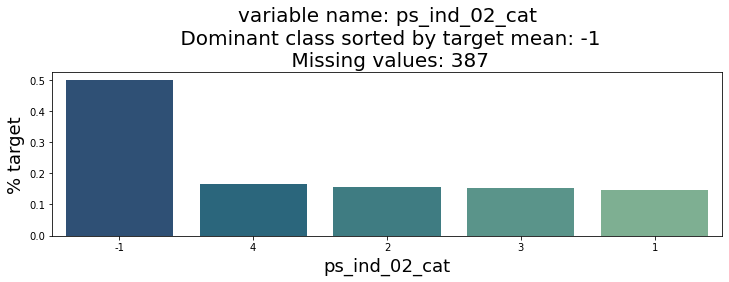

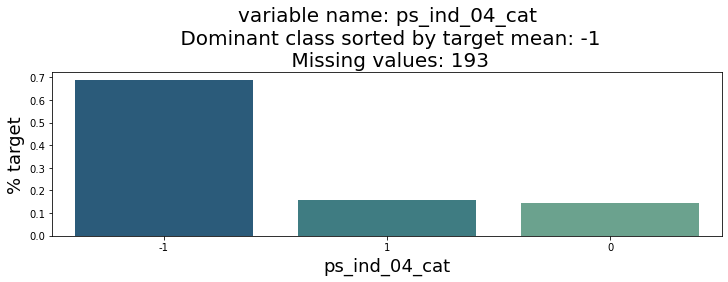

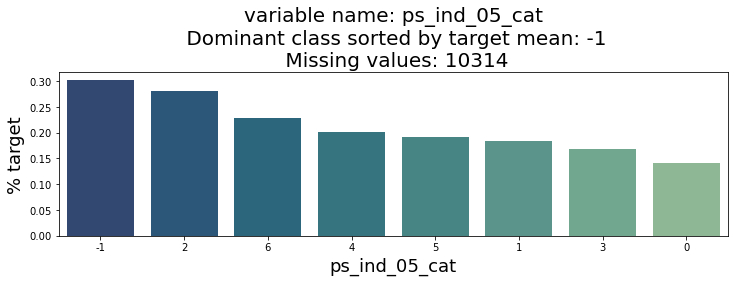

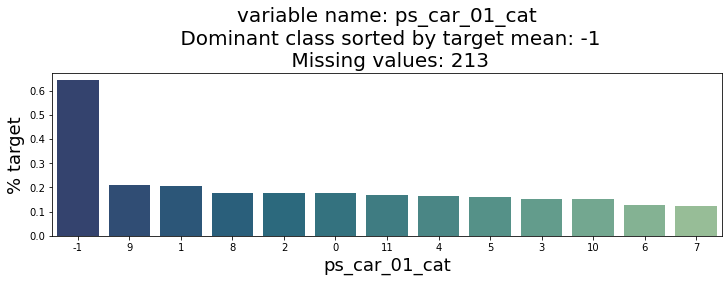

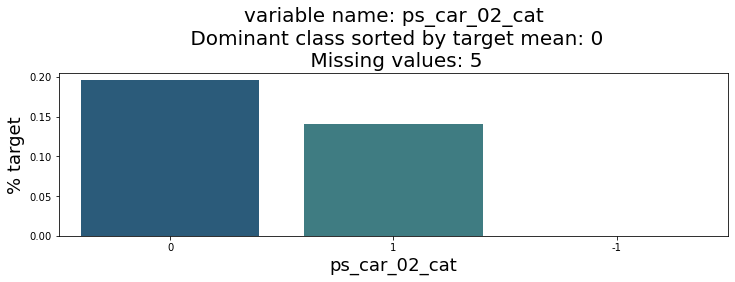

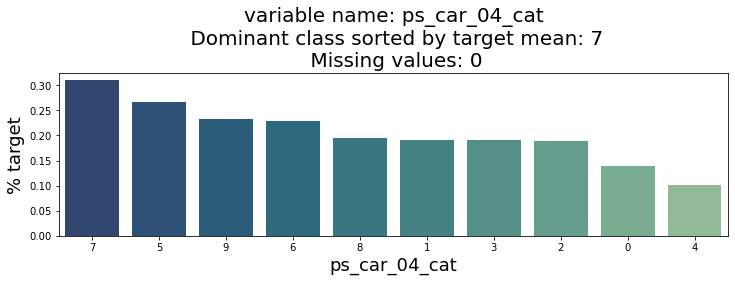

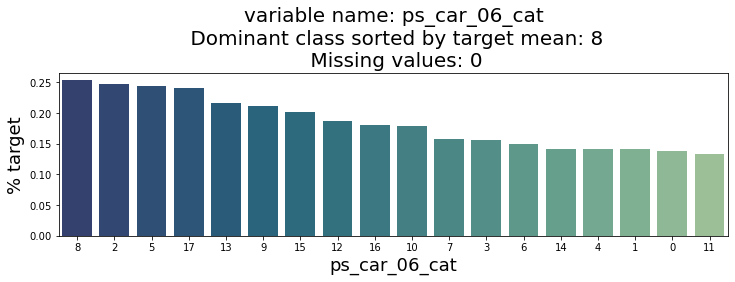

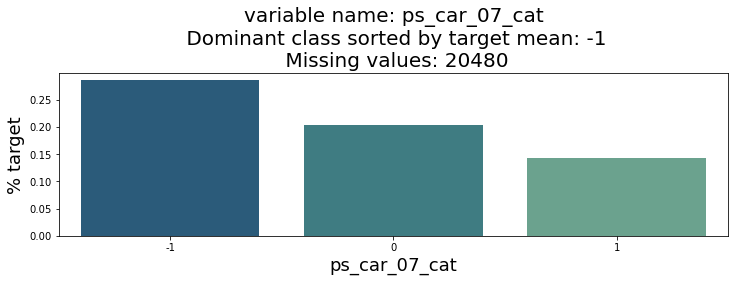

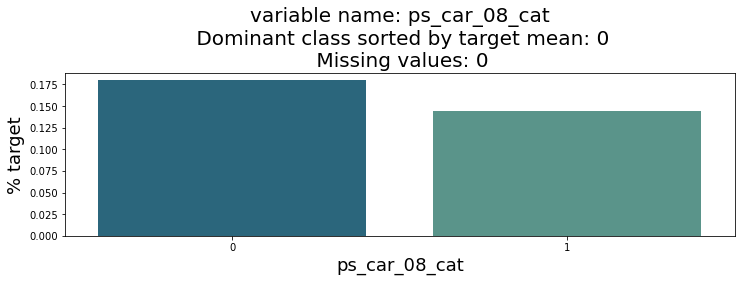

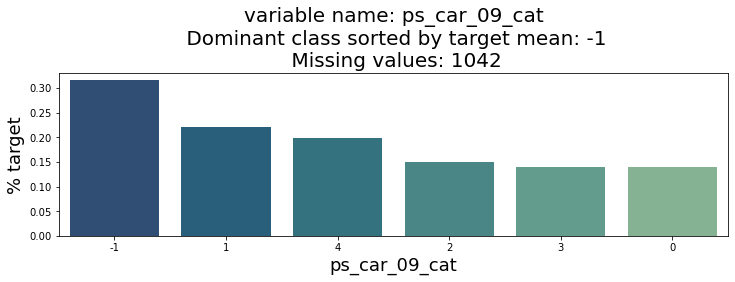

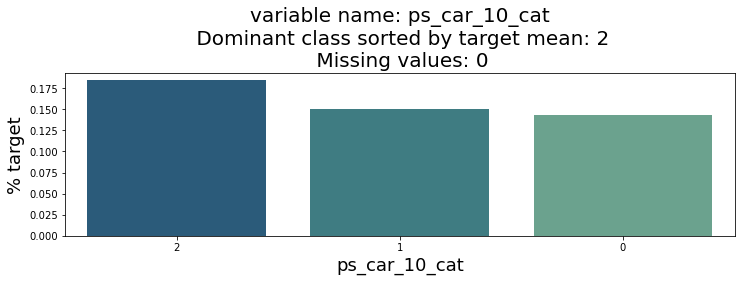

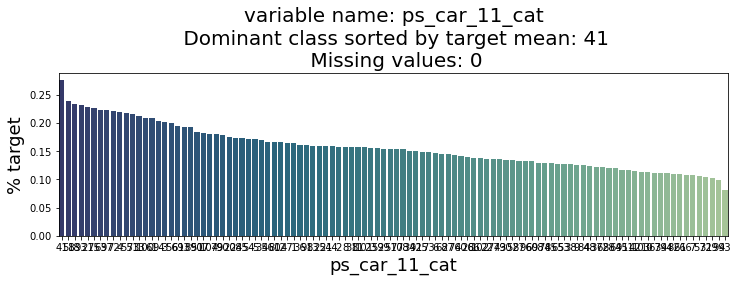

In [48]:
#计算nominal variable中对应target为1的百分比（missing values imputation前）
for col in nom_cols:
    
    #每一个nominal variabl的subplot
    fig, ax = plt.subplots(figsize=(12,3))
    
    #计算每一个nominal variable在target为1的百分比概率(target mean是一样的）并进行降序排序
    nom_pct = fullset_update[[col, 'target']].groupby([col], as_index=False).mean()
    nom_pct.sort_values(by='target', ascending=False, inplace=True)
    
    #柱状图
    sns.barplot(ax=ax, 
                x=col, 
                y='target', 
                data=nom_pct, 
                order=nom_pct[col], 
                palette='crest_r')
    plt.title(f'variable name: {col}\n Dominant class sorted by target mean: {nom_pct[col].iloc[0]}\n Missing values: {metadata.loc[col]["missing"]}', 
              fontsize=20)
    plt.xlabel(col, 
               fontsize=18)
    plt.ylabel('% target', 
               fontsize=18)
    plt.tick_params(axis='both', 
                    which='major', 
                    labelsize=10)
    plt.show()

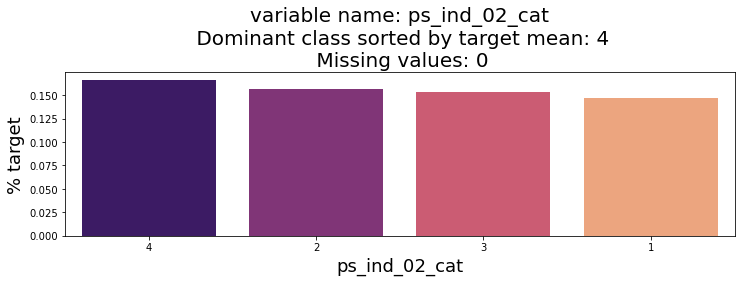

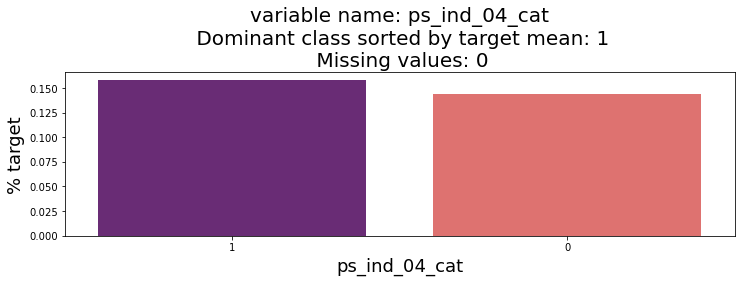

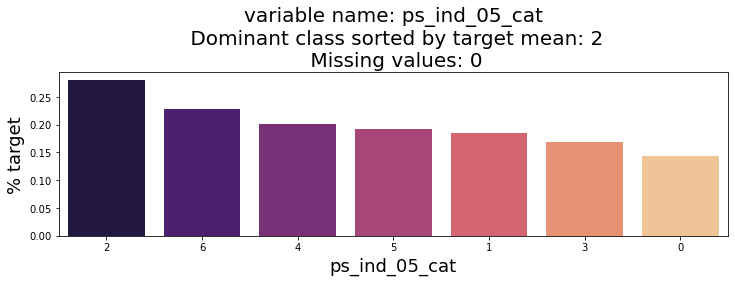

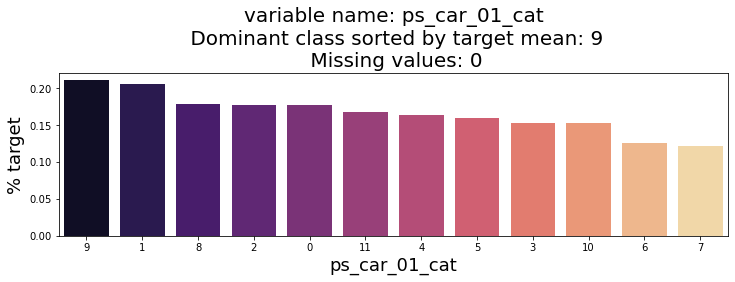

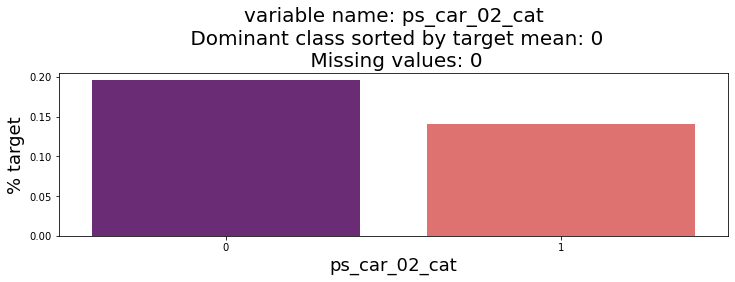

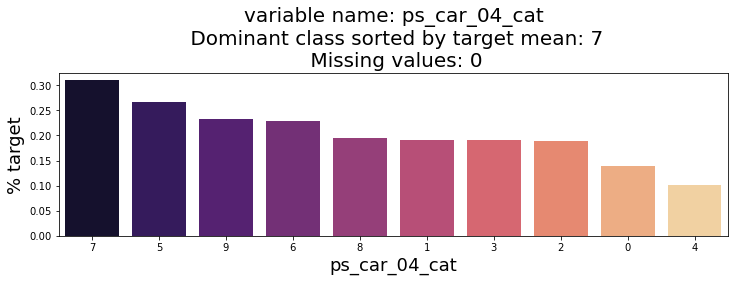

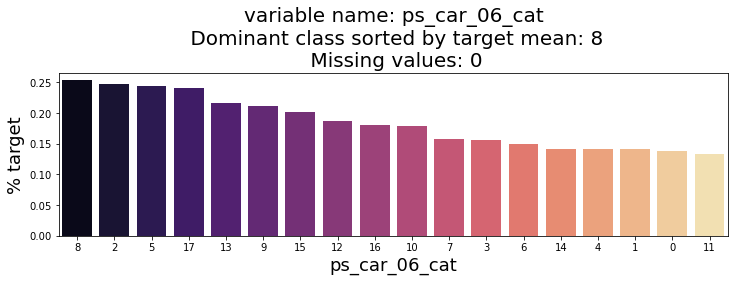

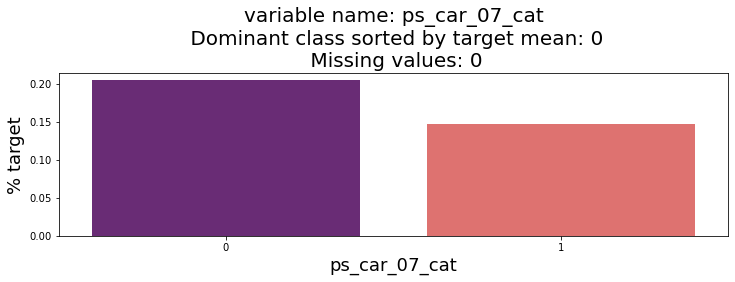

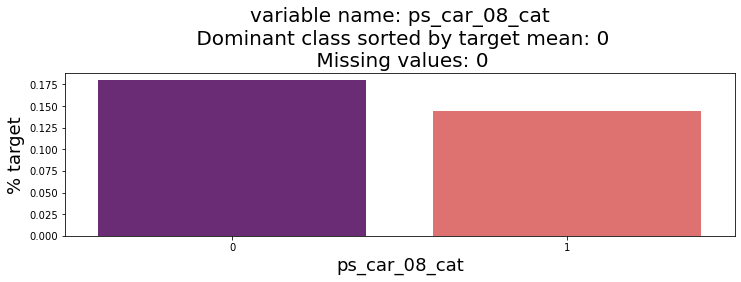

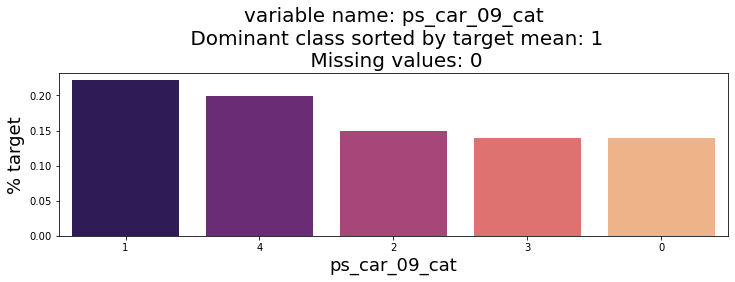

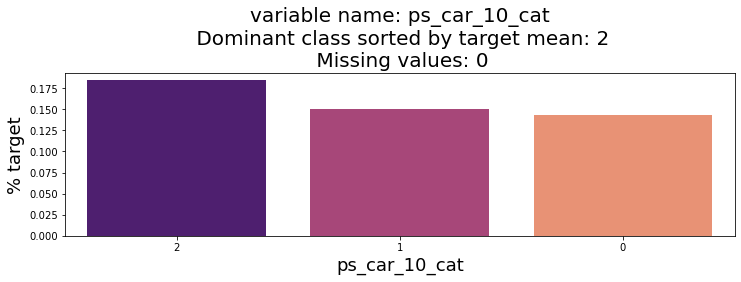

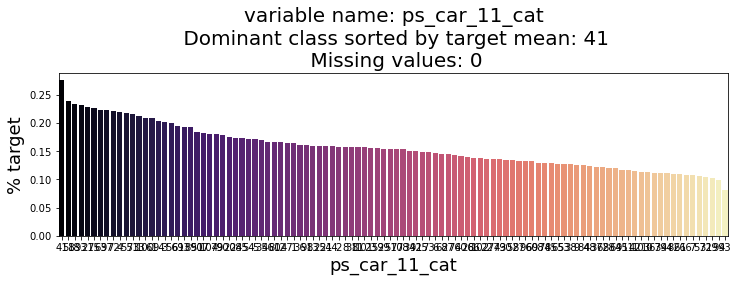

In [49]:
#计算nominal variable中对应target为1的百分比（missing values imputation后）
for col in nom_cols:
    
    #每一个nominal variabl的subplot
    fig, ax = plt.subplots(figsize=(12,3))
    
    #计算每一个nominal variable在target为1的百分比概率(target mean是一样的）并进行降序排序
    nom_pct = fullset_update_cp[[col, 'target']].groupby([col], as_index=False).mean()
    nom_pct.sort_values(by='target', ascending=False, inplace=True)
    
    #柱状图
    sns.barplot(ax=ax, 
                x=col, 
                y='target', 
                data=nom_pct, 
                order=nom_pct[col], 
                palette='magma')
    plt.title(f'variable name: {col}\n Dominant class sorted by target mean: {nom_pct[col].iloc[0]}\n Missing values: {metadata_imp.loc[col]["missing"]}', 
              fontsize=20)
    plt.xlabel(col, 
               fontsize=18)
    plt.ylabel('% target', 
               fontsize=18)
    plt.tick_params(axis='both', 
                    which='major', 
                    labelsize=10)
    plt.show()

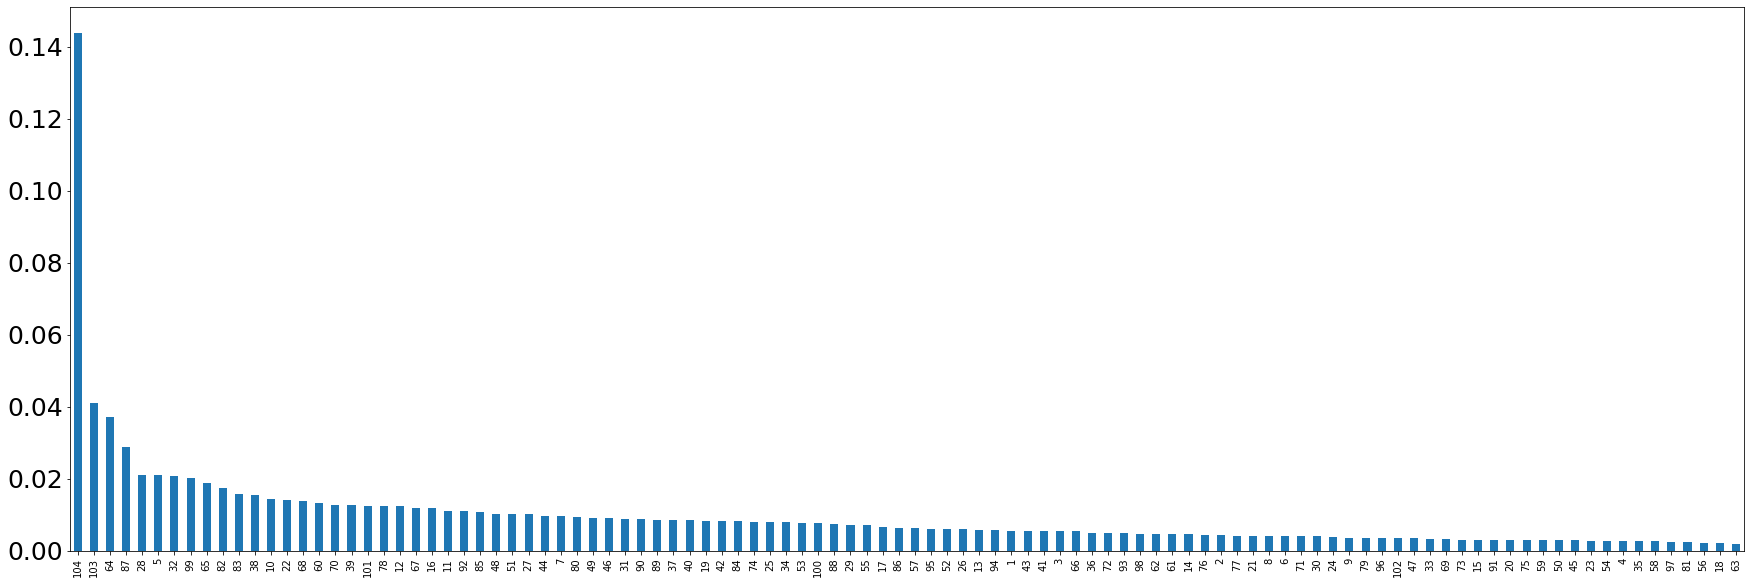

In [50]:
#查看ps_car_11_cat中每一个category的占比
(fullset_update_cp.ps_car_11_cat.value_counts()/fullset_update_cp.shape[0]).plot(kind='bar',
                                                                                figsize=[30,10])
plt.tick_params(axis='y',
               which='major',
               labelsize=25)

**Observations and Takeaways**

* 我们观察到在尚未进行imputation的数据中，多列特征（包括ps_ind_02_cat， ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_07_cat, ps_car_09_cat）在其值为-1时相对应target=1的占比时最高的，超过了25%。
* 这提示我们数列缺失时对目标更有预测性，也就是数据缺失时，司机更可能发起索赔。那么我们不应该对这些列进行填充，而是采取其他手法。
* 经过考虑，此处决定使用inverse_transformation将之前填充的nominal变量进行逆转换，保留-1作为研究类别。

* 我们另外观察到ps_car_11_cat中104这个category占有很大的比例
* 我们后面或将ps_car_11_cat这个nominal variable进行encoding处理

In [51]:
reverse_trans_cols = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 
                      'ps_car_01_cat', 'ps_car_07_cat', 'ps_car_09_cat']

#reverse transformation
fullset_update_cp[reverse_trans_cols] = fullset_update[reverse_trans_cols]

### Binary Variables 分析

In [52]:
#binary variables的列名
bin_cols = metadata[(metadata.level == 'binary') & (metadata.keep)].index

In [53]:
#计算每一个binary variable对应的1/0类别数量
zero_list = []
one_list = []

for col in bin_cols:
    zero_list.append((fullset_update_cp[col]==0).sum())
    one_list.append((fullset_update_cp[col]==1).sum())

In [54]:
#create new bar object with zero counts and corresponding binary column name
trace1 = go.Bar(x=bin_cols,
               y=zero_list,
               name='Zero Count')

#create new bar object with one counts and corresponding binary column name
trace2 = go.Bar(x=bin_cols,
               y=one_list,
               name='One Count')

#combine data and specify layout
data = [trace1,trace2]

layout = go.Layout(barmode='stack',
                  title='Count of 1 and 0 in binary variables (target included)')

#plot figure
fig = go.Figure(data=data, layout=layout)
fig

这里我们可以观察到，ps_ind_10_bin，ps_ind_11_bin，ps_ind_12_bin，ps_ind_13_bin都是完全被0占有的。因为这些feature包含了太少为1的值，这种倾向让人怀疑这些feature是否真的有利于模型的建立。

### Ordinal Variables 分析

In [55]:
#ordinal variables的列名
ord_cols = metadata[(metadata.level == 'ordinal') & (metadata.keep)].index

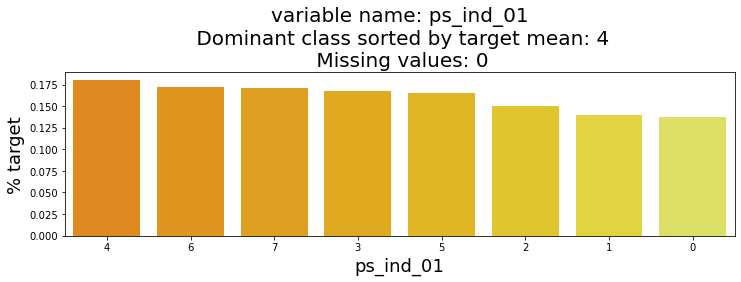

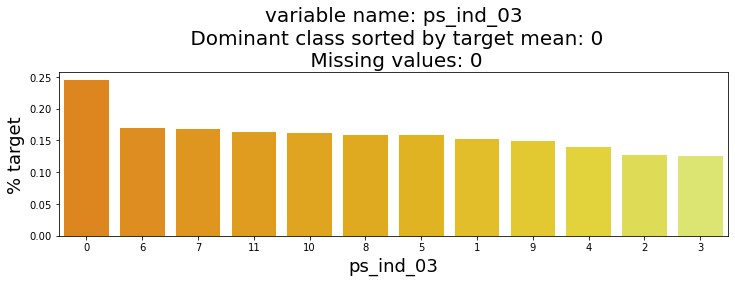

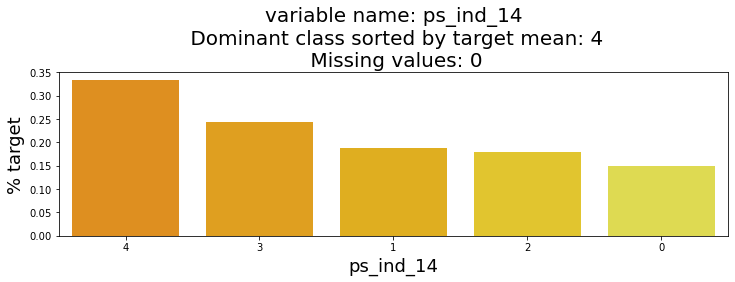

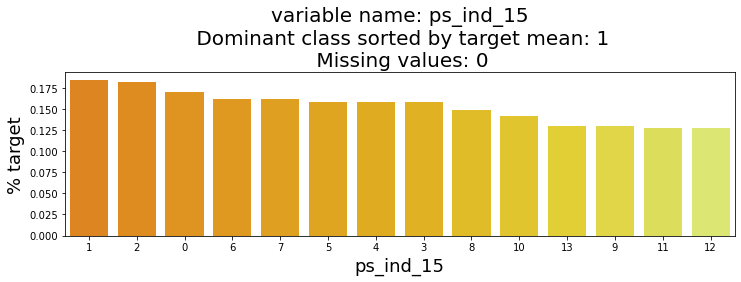

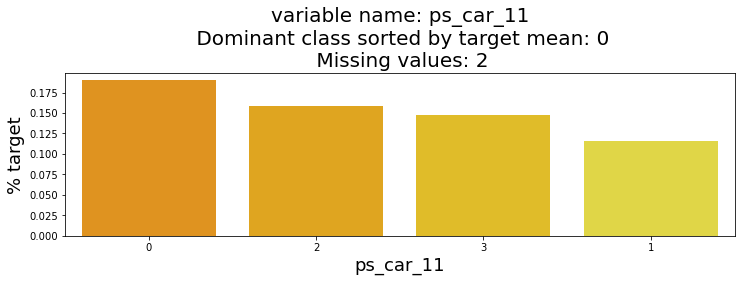

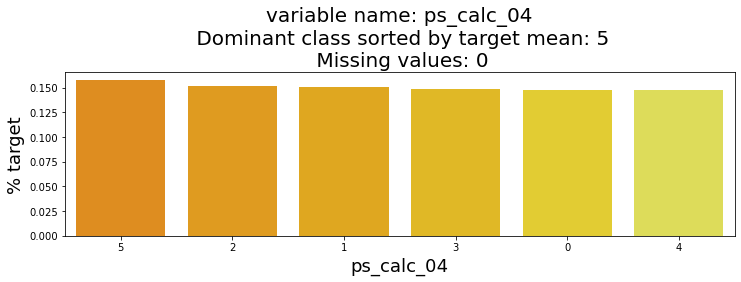

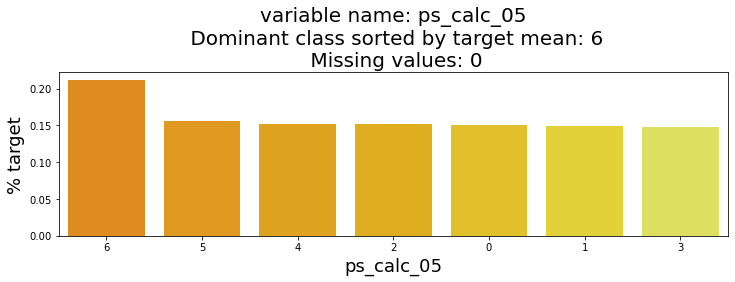

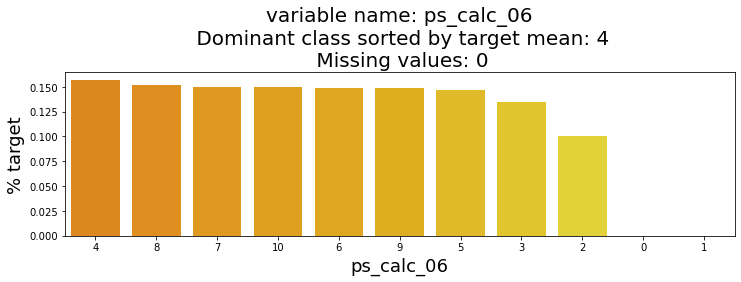

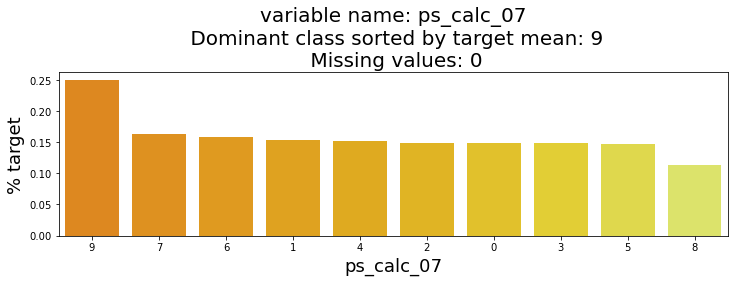

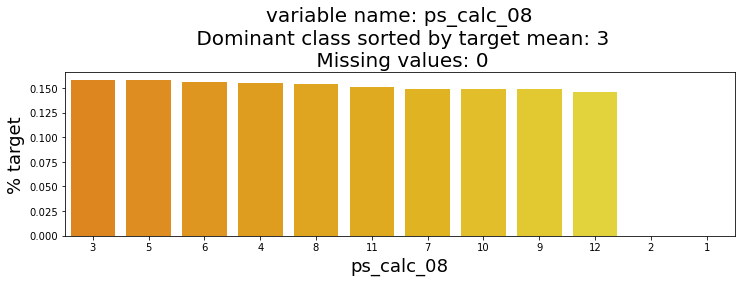

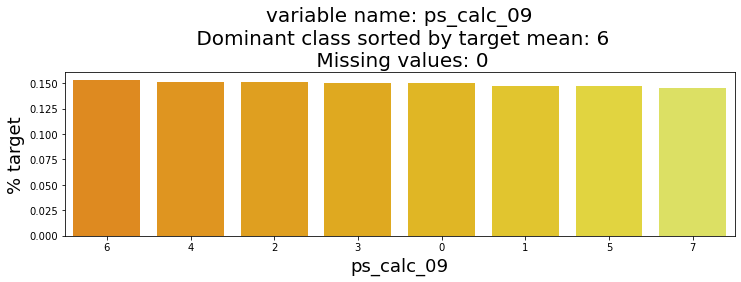

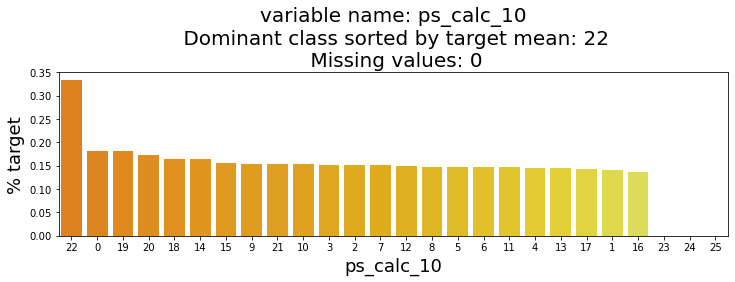

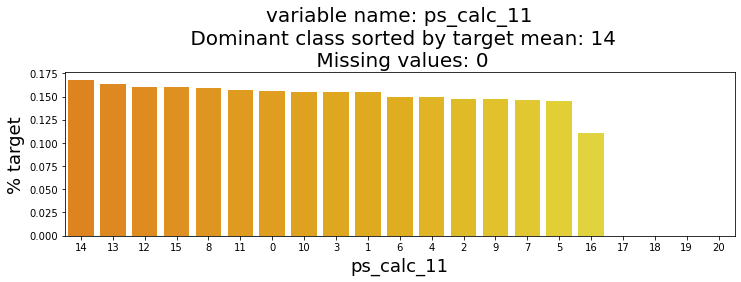

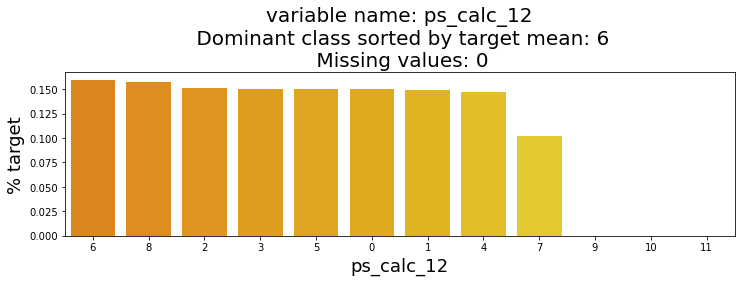

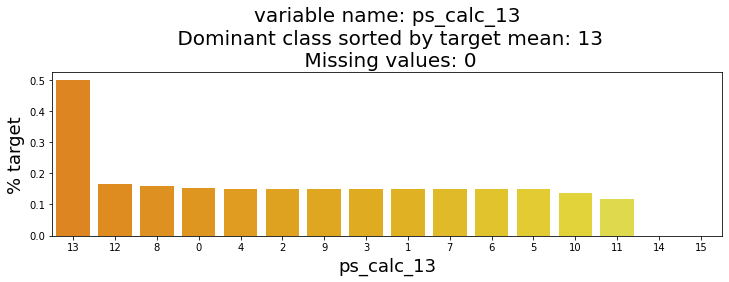

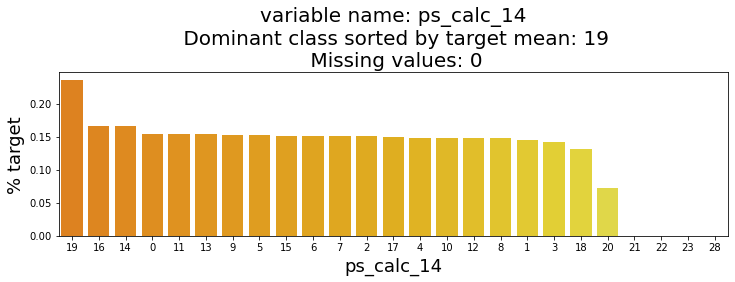

In [56]:
for col in ord_cols:
    
    #每一个ordinal variabl的subplot
    fig, ax = plt.subplots(figsize=(12,3))
    
    #计算每一个ordinal variable在target为1的百分比概率(target mean是一样的）并进行降序排序
    ord_pct = fullset_update_cp[[col, 'target']].groupby([col], as_index=False).mean()
    ord_pct.sort_values(by='target', ascending=False, inplace=True)
    
    #柱状图
    sns.barplot(ax=ax, 
                x=col, 
                y='target', 
                data=ord_pct, 
                order=ord_pct[col], 
                palette='Wistia_r')
    plt.title(f'variable name: {col}\n Dominant class sorted by target mean: {ord_pct[col].iloc[0]}\n Missing values: {metadata.loc[col]["missing"]}', 
              fontsize=20)
    plt.xlabel(col, 
               fontsize=18)
    plt.ylabel('% target', 
               fontsize=18)
    plt.tick_params(axis='both', 
                    which='major', 
                    labelsize=10)
    plt.show()

### 连续性特征分析

### 相关性分析

In [57]:
#continuous variables的列名
cont_cols = metadata[(metadata.level.isin(['ratio','interval']))&(metadata.keep)].index
cont_cols

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object', name='colname')

In [58]:
sns.set_theme(style='whitegrid')

#计算correlation matrix
corr_matrix = fullset_update_cp.corr().stack().reset_index(name='correlation')

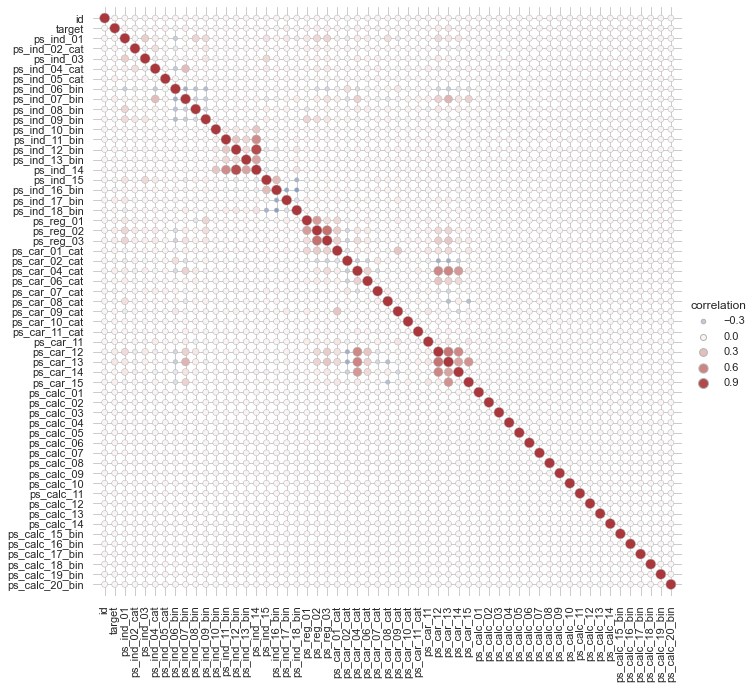

In [59]:
#根据上面correlation matrix画不同大小和颜色的散点图
g = sns.relplot(data=corr_matrix,
              x='level_0',
              y='level_1',
              hue='correlation',
              size='correlation',
              palette='vlag',
              hue_norm=(-1,1),
              edgecolor='.7',
              height=10,
              sizes=(20,100),
              size_norm=(-.2,.8))

#设置轴标签
g.set(xlabel='',
     ylabel='',
     aspect='equal')

#remove top and right spine
g.despine(left=True,
         bottom=True)

#add paddings to axes
g.ax.margins(.02)

#rotate x axis
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

for artist in g.legend.legendHandles:
    artist.set_edgecolor('.7')

<AxesSubplot:>

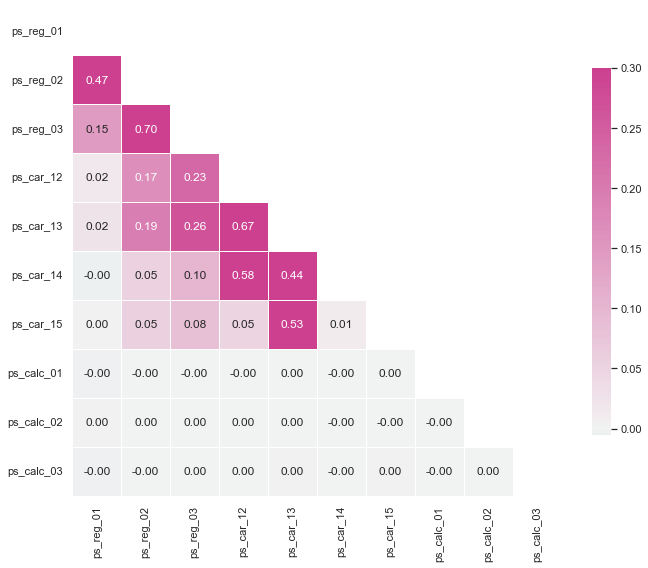

In [60]:
#create mask for upper triangle
corr_matrix2 = fullset_update_cp[cont_cols].corr()
mask = np.triu(np.ones_like(corr_matrix2, 
                            dtype=bool))

#为correlation matrix画一个热力图
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, -20, as_cmap=True)
sns.heatmap(corr_matrix2,
           mask=mask,
           cmap=cmap,
           vmax=.3,
           center=0,
           square=True,
           linewidths=.5,
           cbar_kws={'shrink':.75},
           annot=True,
           fmt='.2f')

我们发现在一下这些variables之间有比较强的correlation：
* ps_reg_02 and ps_reg_03 (0.69)
* ps_car_12 and ps_car_13 (0.67)
* ps_car_14 and ps_car_12 (0.58)
* ps_car_13 and ps_car_15 (0.53)
* ps_reg_01 and ps_reg_02 (0.47)

### 回归分析

In [61]:
fullset_sample = fullset_update_cp.sample(2000)

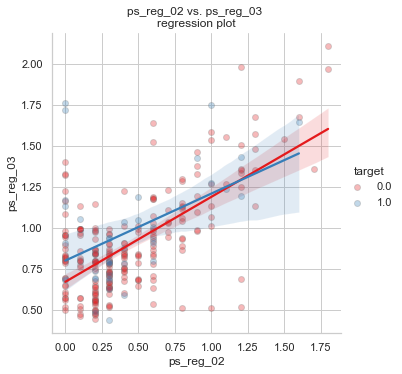

In [62]:
#探索ps_reg_02和ps_reg_03间的线性关系
sns.lmplot(x='ps_reg_02',
          y='ps_reg_03',
          data=fullset_sample,
          hue='target',
          palette='Set1',
          height=5,
          scatter_kws={'alpha':0.3,
                       'edgecolor':'grey'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

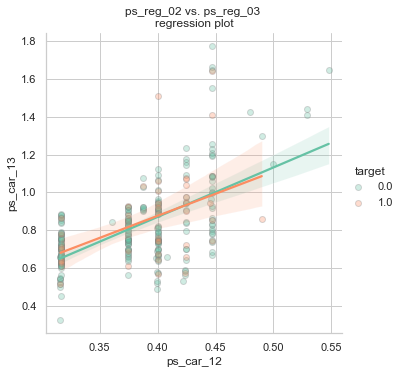

In [63]:
#探索ps_car_12和ps_car_13间的线性关系
sns.lmplot(x='ps_car_12',
          y='ps_car_13',
          data=fullset_sample,
          hue='target',
          palette='Set2',
          height=5,
          scatter_kws={'alpha':0.3,
                       'edgecolor':'grey'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

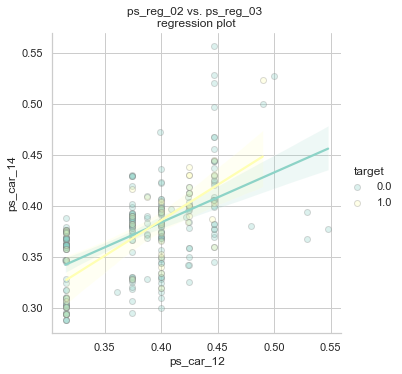

In [64]:
#探索ps_car_12和ps_car_14间的线性关系
sns.lmplot(x='ps_car_12',
          y='ps_car_14',
          data=fullset_sample,
          hue='target',
          palette='Set3',
          height=5,
          scatter_kws={'alpha':0.3,
                       'edgecolor':'grey'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

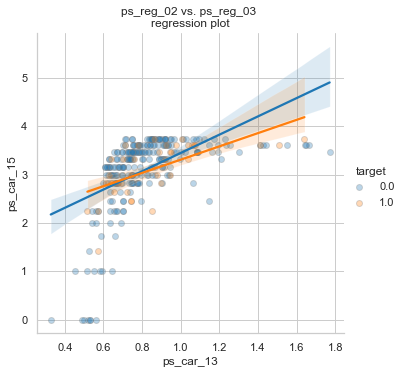

In [65]:
#探索ps_car_13和ps_car_15间的线性关系
sns.lmplot(x='ps_car_13',
          y='ps_car_15',
          data=fullset_sample,
          hue='target',
          palette='tab10',
          height=5,
          scatter_kws={'alpha':0.3,
                       'edgecolor':'grey'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

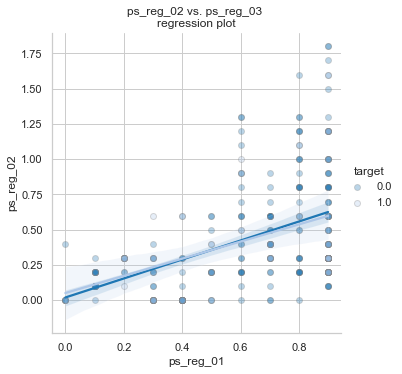

In [66]:
#探索ps_reg_01和ps_reg_02间的线性关系
sns.lmplot(x='ps_reg_01',
          y='ps_reg_02',
          data=fullset_sample,
          hue='target',
          palette='tab20',
          height=5,
          scatter_kws={'alpha':0.3,
                       'edgecolor':'grey'}).set(title='ps_reg_02 vs. ps_reg_03 \nregression plot')

### 特征重要度分析

In [67]:
train_imp = fullset_update_cp[~fullset_update_cp['target'].isna()]
test_imp = fullset_update_cp[fullset_update_cp['target'].isna()]
train_imp

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0             7     0.0          2              2          5              1   
1            20     0.0          2              1          3              1   
2            28     1.0          1              1          2              0   
3            43     0.0          1              1          3              1   
4            48     0.0          5              1          3              1   
...         ...     ...        ...            ...        ...            ...   
144622  1487976     0.0          0              1          7              1   
144623  1487983     0.0          1              1          2              0   
144624  1488005     0.0          3              2          3              1   
144625  1488017     0.0          1              1         10              0   
144626  1488027     0.0          0              1          8              0   

        ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ...  \
0                   0              0              1              0  ...   
1                   0              0              1              0  ...   
2                   0              0              1              0  ...   
3                   0              0              1              0  ...   
4                   0              0              1              0  ...   
...               ...            ...            ...            ...  ...   
144622              0              0              1              0  ...   
144623              0              1              0              0  ...   
144624              0              0              1              0  ...   
144625              0              1              0              0  ...   
144626              0              1              0              0  ...   

        ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0                9           1           5           8               0   
1                3           0           0          10               0   
2                3           5           0           6               0   
3                2           0           4           3               0   
4                5           2           6           7               0   
...            ...         ...         ...         ...             ...   
144622           6           1           4          12               0   
144623           6           0           1          11               1   
144624           5           2           1           6               0   
144625           3           2           2           6               0   
144626           4           4           3           8               0   

        ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0                    1               1               0               0   
1                    1               0               0               1   
2                    1               0               0               1   
3                    0               1               0               1   
4                    1               1               0               1   
...                ...             ...             ...             ...   
144622               1               1               0               0   
144623               1               0               0               1   
144624               0               0               0               0   
144625               0               1               0               0   
144626               1               0               0               0   

        ps_calc_20_bin  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
144622               0  
144623               1  
144624               0  
144625               0  
144626               0  

[144627 rows x 57 columns]

In [68]:
#Plot feature importance of training set
plt.figure(figsize=[100,20])

X = train_imp.drop(['id','target'], axis=1)
y = train_imp.target

model = XGBClassifier()

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Figure size 7200x1440 with 0 Axes>

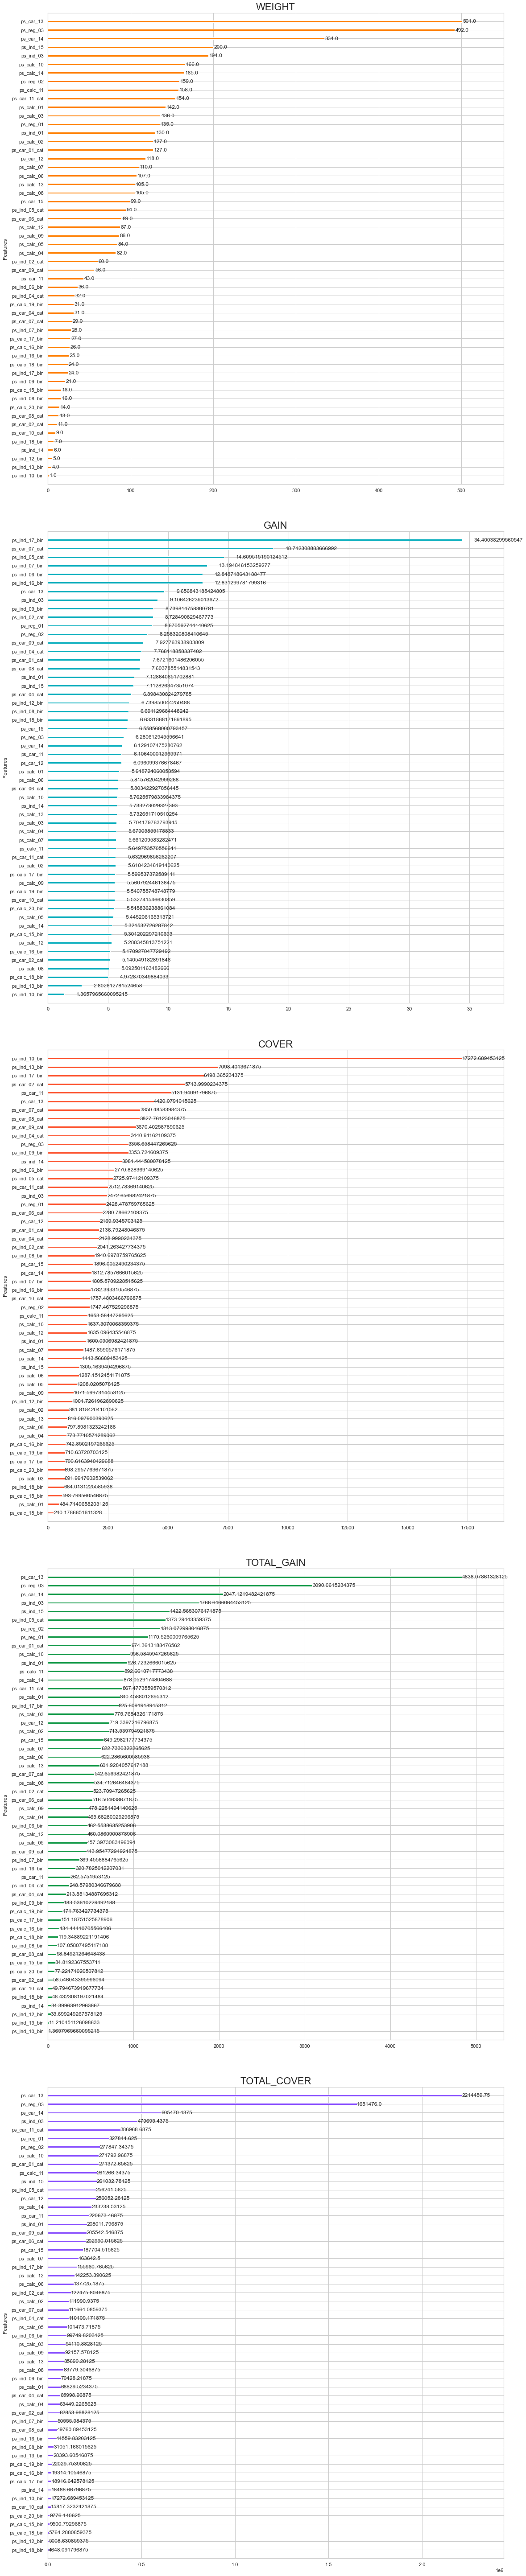

In [69]:
#定义subplot的grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', #特定特征在模型数中出现的相对次数的百分比
         'gain', #相应特征对模型的相对贡献
         'cover', #该特征相关的观察的相对数量
         'total_gain',
         'total_cover']

colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']

for ty, ax, color in zip(types, axs.ravel(), colors):
    
    #filter df for ticker and plot on specified axes
    plot_importance(ax=ax,
                   booster=model,
                   importance_type=ty,
                   color=color)
    
    #调整格式
    ax.set_title(ty.upper(), fontsize=22)
    ax.set_xlabel('')
    
plt.show()

## 特征工程

### Feature Encoding 特征编码 (for categorical variables)

**Observations**
 * 我们观察到ordinal的变量已经做好encoding了，并不用重新再用OrdinalEncoder或LabelEncoder来encode数据。
 * 我们发现数据也包含了许多变量类型为nominal的变量，通常来说可以使用OneHotEncoder来给数据进行编码。但是这里本身就有50以上的维度，再进行one hot encoding就很容易让数据上升到一百以上的维度，这样会给后面建模的流程带来困难。
 * 如果我们不给nominal variables进行one hot encoding的话，那么有少许category比较多的variables，例如上面观察到的ps_car_11_cat就含有几十个categories。这种情况我们应该尝试用别的方法来处理这个variable。
 
**Conclusion**
* 我们决定对ps_car_11_cat这个特征进行target encoding，将类别换成target关于这一类的均值。但是考虑到target的均值可能会使得target的分布信息在feature中泄露，这可能会导致了overfitting的情况。其次，如果两个categories在target的均值是相似的，那么我们可能会丢失一些有用数据。那么我们决定在target encoding时加入一些noise和smoothing。
* 除了ps_car_11_cat以外的特征，我们目前先不予处理。

In [70]:
#本method对一个输入的series增加规定level内随机的noise
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

In [195]:
def target_encode(trn_series=None,
                 tst_series=None,
                 target=None,
                 min_samples_leaf=1,
                 smoothing=1,
                 noise_level=0):
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    
    #计算每一类关于target的category mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean','count'])
    
    #smoothing
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    
    #计算所有target的mean as prior
    prior = target.mean()
    
    #对于count特别多的category，采取消减器关于target的mean的权值
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean','count'],
                  axis=1,
                 inplace=True)
    
    ft_trn_series = pd.merge(trn_series.to_frame(trn_series.name),
                            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                            on=trn_series.name,
                            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    ft_trn_series.index = trn_series.index
    
    ft_tst_series = pd.merge(tst_series.to_frame(tst_series.name),
                            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
                            on=tst_series.name,
                            how='left')['average'].rename(tst_series.name + '_mean').fillna(prior)
                                                          
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)
    

In [72]:
#将ps_car_11_cat这列用之前定义的target_encode方法来encode
train_encoded, test_encoded = target_encode(train_imp['ps_car_11_cat'],
                                           test_imp['ps_car_11_cat'],
                                           target=train_imp.target,
                                           min_samples_leaf=100,
                                           smoothing=10,
                                           noise_level=0.01)

In [73]:
train_imp['ps_car_11_cat_tar_enc'] = train_encoded.astype('float64')
test_imp['ps_car_11_cat_tar_enc'] = test_encoded.astype('float64')

/var/folders/3w/z6sq_gnx1q3_xqffyzv52n480000gn/T/ipykernel_48506/1610237710.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3w/z6sq_gnx1q3_xqffyzv52n480000gn/T/ipykernel_48506/1610237710.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
#去除encode前的数据
train_clean = train_imp.drop('ps_car_11_cat', axis=1)
test_clean = test_imp.drop('ps_car_11_cat', axis=1)

In [131]:
#将清洗好的数据存到csv文档里
#train_clean.to_csv('train_clean.csv')
#test_clean.to_csv('test_clean.csv')

In [132]:
fullset_clean = pd.concat([train_clean,test_clean], ignore_index=True)

In [133]:
final_meta = meta(train_clean,test_clean)

### Feature Binningh 特征分箱 (for continuous variables)

<AxesSubplot:>

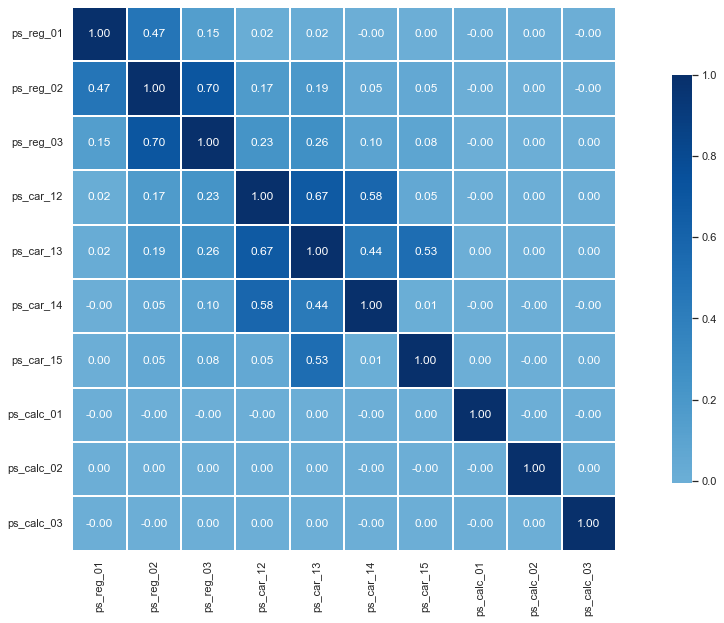

In [134]:
#用heatmap展示correlation matrix
plt.figure(figsize = [20,10])   
sns.heatmap(data = fullset_clean[cont_cols].corr(), 
            vmax=1,
            center=0,
            square=True,
           annot = True,  
          fmt='.2f',
           cmap = 'Blues',
           linewidths = .3,
           cbar_kws={"shrink": .75})

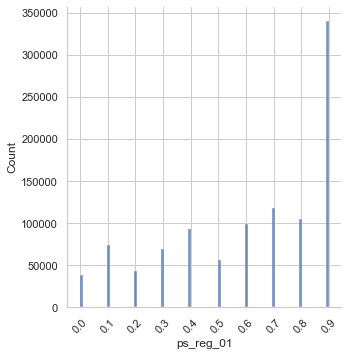

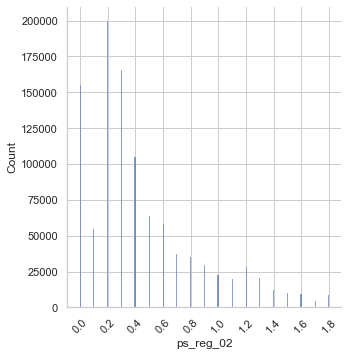

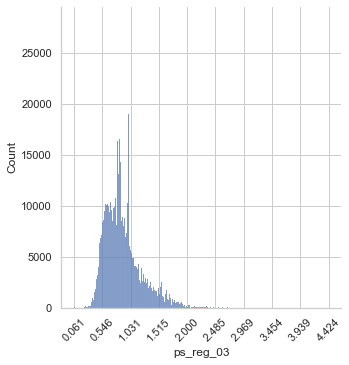

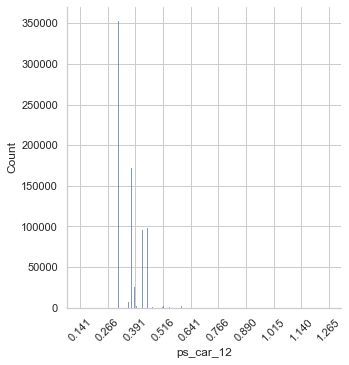

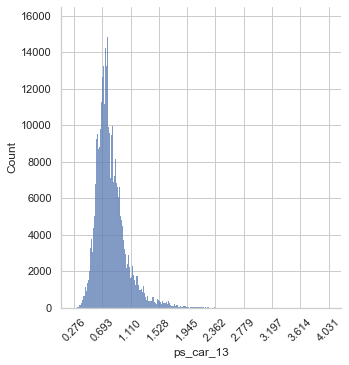

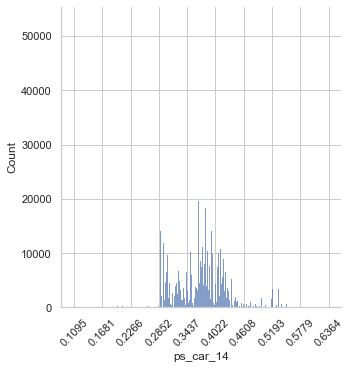

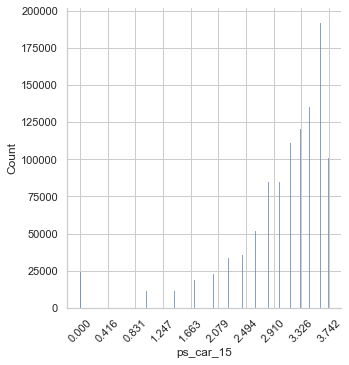

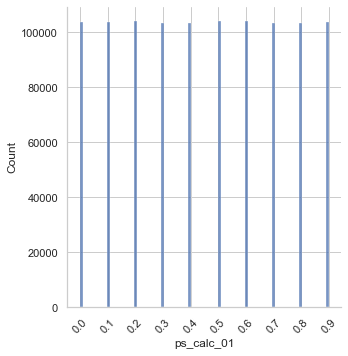

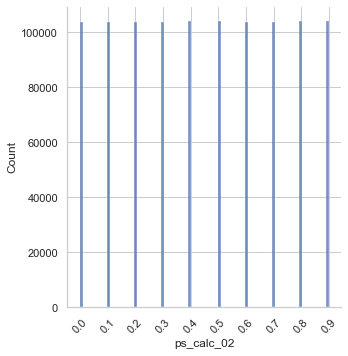

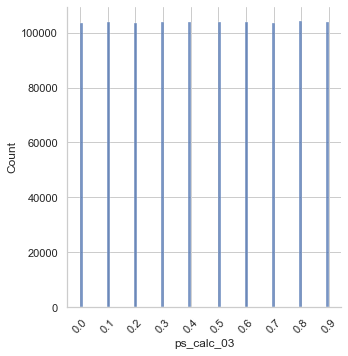

In [135]:
#查看continuous variables的数据分布
for col in cont_cols:
    sns.displot(fullset_clean[col])
    plt.xticks(ticks=np.linspace(start=fullset_clean[col].min(),
                                stop=fullset_clean[col].max(),
                                num=10),
              rotation=45)

**Observation**

我们能有一些变量虽然是连续型的，但是并不是会形成传统意义上的概率分布。这些变量的分布中会有离散型数据的性质出现，并且有很多尖峰的情况，普遍对应着肥尾。

**Takeaway**

* 因此我们尝试采用特征离散化，来达到以下目的：
    * 强化突出特征的关键性信息（主要集中在尖峰附近），并简化特征，避免过拟合
    * 避免丢失离群值，因为离群值无法定义为异常值，并不是分布的异常就说明其不合理性，在此没有更多的证据来证明，所以不剔除离群值。
* 同时我们使用WOE（Weight of Evidence）来进行编码分箱
    * WOE衡量因子和target之间的相关程度，IV代表特征的预测能力
    * WOE对不同渠道数据进行尺度统一，各分箱内坏好比（Odds）相较于总体坏好比的差异性，而且能筛选高IV特征但注意数据泄露的发生

In [136]:
#WOE编码定义
def woe_iv_encoding(data, feat, target, max_intervals, verbose=False):
    
    feat_bins = pd.qcut(x=data[feat],
                       q=max_intervals,
                       duplicates='drop')
    gi = pd.crosstab(feat_bins, data[target])
    gb = pd.Series(data=data[target]).value_counts()
    
    bad = gi[1]/gi[0]
    good = gb[1]/gb[0]
    
    #计算WOE
    woe = np.log(bad) - np.log(good)
    
    #计算iv
    iv = (bad - good) * woe
    
    #计算特征的iv
    feat_iv = iv.sum()
    if verbose == True:
        print(f'根据当前的间隔数{max_intervals}，特征{feat}所计算的总information value为：{feat_iv}')
        print('='*80)
        
    #映射
    dic = iv.to_dict()
    
    #连续型变量离散化
    iv_bins = feat_bins.map(dic)
    
    return iv_bins.astype('float64')

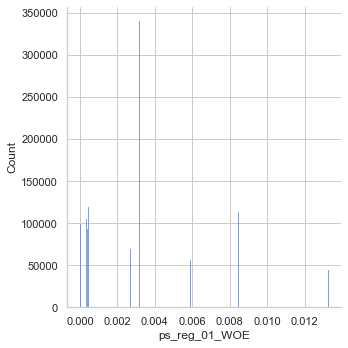

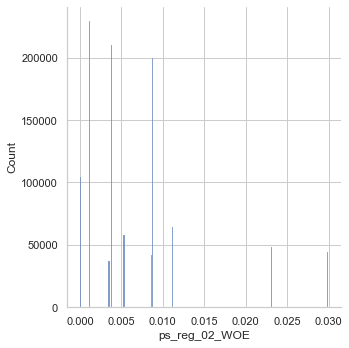

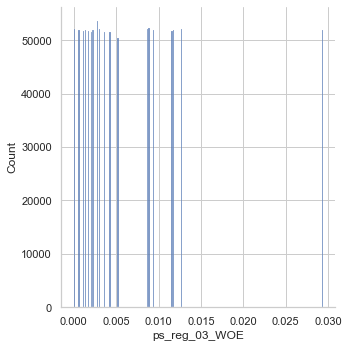

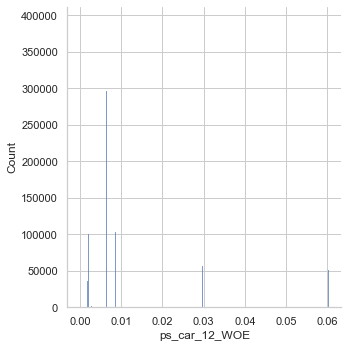

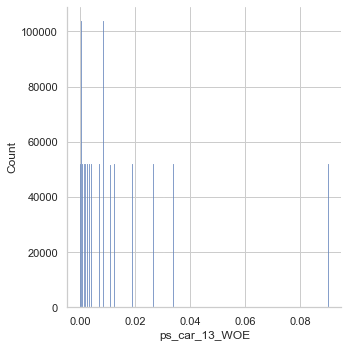

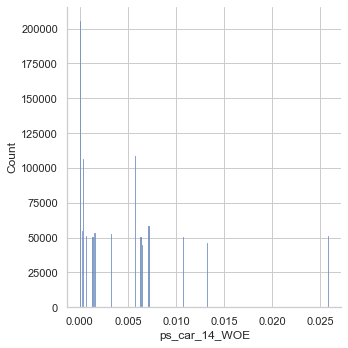

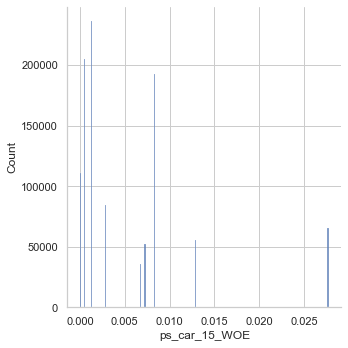

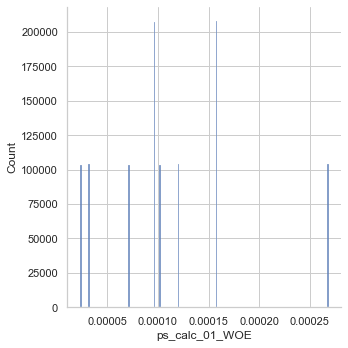

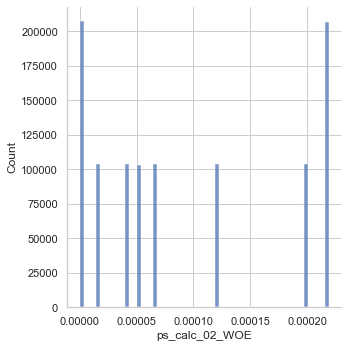

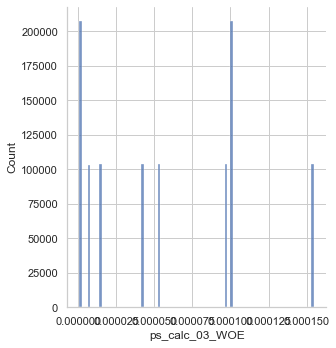

In [137]:
#WOE编码执行
for col in cont_cols:
    fullset_clean[f'{col}_WOE'] = woe_iv_encoding(data=fullset_clean,
                                                 feat=col,
                                                 target='target',
                                                 max_intervals=20)
    sns.displot(fullset_clean[f'{col}_WOE'])

### 特征交互

**Observation**

我们从之前绘制的correlation matrix heatmap能看到，部分连续型变量有比较大的相关性，我不能把他们都带入模型中，因为相关特征不能提升模型表现。对于线性模型会造成collinearity问题；对树形模型基于各特征的信息增益对其分割，适合处理不同特征之间的交互性，但是高相关性会掩盖其中的交互性。

**Takeaway**

* 因此，我们需要用特征交互来达到对于不同的特征组合都能进行有效预测的目标。
* 特征交互也叫特征组合，通过将两个或多个特征组合起来，进行一系列操作，来实现对样本空间的非线性变换，增加模型的非线性能力。

In [138]:
poly = PolynomialFeatures(degree=2,
                         interaction_only=True,
                         include_bias=False)

interactions = pd.DataFrame(data=poly.fit_transform(fullset_clean[cont_cols]),
                           columns=poly.get_feature_names(input_features=cont_cols))

#去除原本continuous variables
interactions.drop(cont_cols,
                 axis=1,
                 inplace=True)

#加上交互后的continuous variables
print('特征交互前，训练集有 {}个变量 '.format(fullset_clean.shape[1]))
fullset_clean = pd.concat([fullset_clean, interactions], axis=1)
print('特征交互后，训练集有 {}个变量'.format(fullset_clean.shape[1]))

特征交互前，训练集有 67个变量 
特征交互后，训练集有 112个变量


### PCA

In [151]:
#提取train的特征和target
X = fullset_clean[~fullset_clean['target'].isna()].drop(['id','target'], axis=1)
y = fullset_clean[~fullset_clean['target'].isna()].target

In [152]:
#执行pca
n_comp = 35
pca = PCA(n_components=n_comp,
         svd_solver='full',
         random_state=1001)

X_pca = pca.fit_transform(X)

print('Total Explained variance: %.3f' % pca.explained_variance_ratio_.sum())

Total Explained variance: 0.988


Text(12, 0.97, 'cumulative explained var: \n0.919')

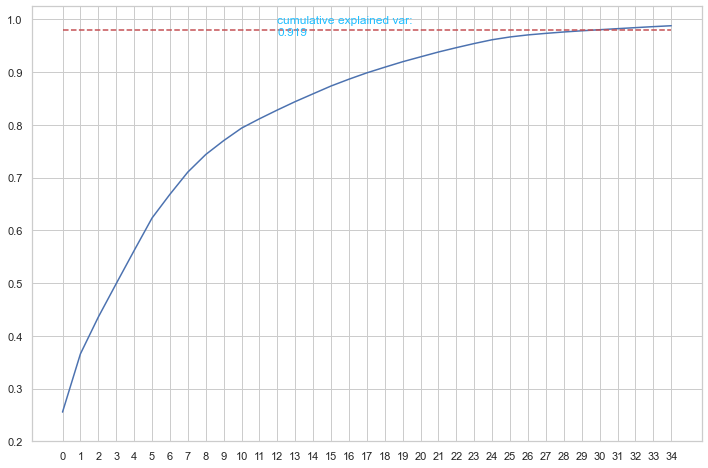

In [153]:
plt.figure(figsize=[12,8])

pd.Series(pca.explained_variance_ratio_).cumsum().plot()

plt.plot(range(n_comp), 
         [0.98]*35,
        'r--')
plt.xticks(ticks=range(n_comp))
plt.yticks(ticks=np.linspace(0.2,1,9))
plt.text(12,0.97,'cumulative explained var: \n0.919',fontsize = 12, color = '#20beff')

### 特征筛选

#### 基于统计指标

In [154]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(fullset_clean.drop(['id','target'], axis=1))

#反转boolean val
f = np.vectorize(lambda x : not x)

v = fullset_clean.drop(['id','target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

19 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_tar_enc', 'ps_reg_01_WOE', 'ps_reg_02_WOE', 'ps_reg_03_WOE', 'ps_car_12_WOE', 'ps_car_13_WOE', 'ps_car_14_WOE', 'ps_car_15_WOE', 'ps_calc_01_WOE', 'ps_calc_02_WOE', 'ps_calc_03_WOE', 'ps_car_12 ps_car_14']


#### 基于模型指标

In [155]:
plt.figure(figsize = [100,20])

model = XGBClassifier()

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<Figure size 7200x1440 with 0 Axes>

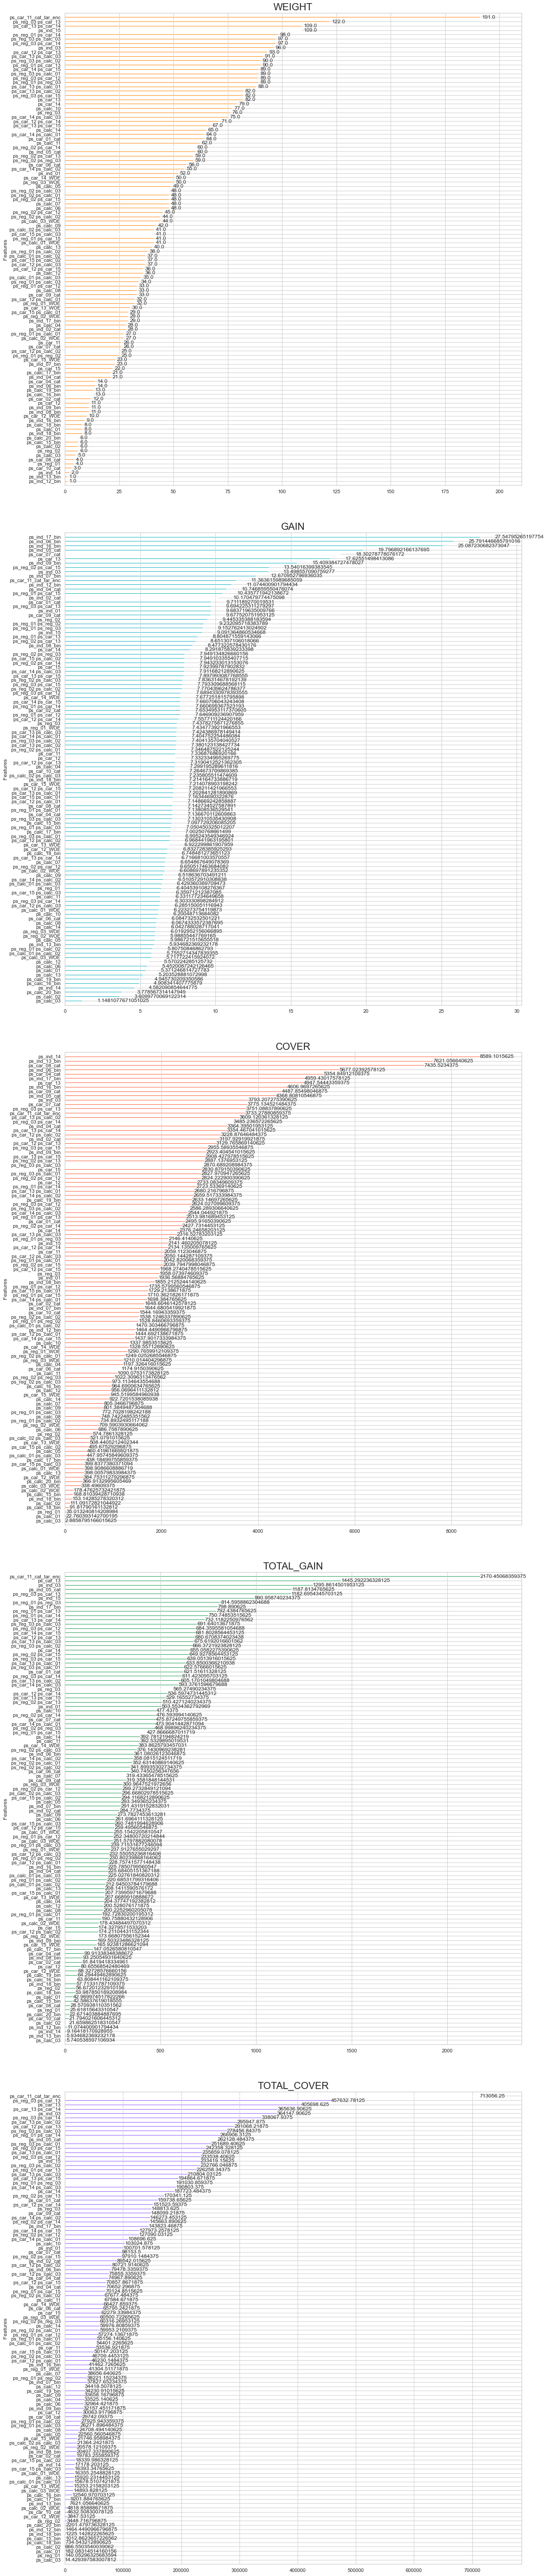

In [156]:
#The code here reuse code from the EDA part

# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 80))
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

# loop through tickers and axes
colors = ['#ff7f01','#08aebd','#fc5531','#139948','#8950fe']
for ty, ax, color in zip(types, axs.ravel(), colors):
    
    # filter df for ticker and plot on specified axes
    plot_importance(ax = ax, booster = model,importance_type=ty, color = color)

    # chart formatting
    ax.set_title(ty.upper(),fontsize = 22)
    ax.set_xlabel("")

plt.show()

In [160]:
#selecting features based on importance weights
feat_dict = {}
for thres in ['median','mean','1.25*mean']:
    model_select = SelectFromModel(model, threshold=thres, prefit=True)
    print(f'筛选前总计：{X.shape[1]}个特征')
    n_features = model_select.transform(X.values).shape[1]
    print(f'筛选后总计： {n_features}个特征[{thres}]')
    print('-'*60)
    selected_vars = list(X.columns[model_select.get_support()])
    feat_dict[thres] = selected_vars

筛选前总计：110个特征
筛选后总计： 55个特征[median]
------------------------------------------------------------
筛选前总计：110个特征
筛选后总计： 27个特征[mean]
------------------------------------------------------------
筛选前总计：110个特征
筛选后总计： 15个特征[1.25*mean]
------------------------------------------------------------


In [161]:
for ty in types:
    feat_dict[ty] = list(model.get_booster().get_score(importance_type=ty).keys())

In [162]:
#使用mean的threshold筛选最终特征并存入final_train和final_test中
final_train = fullset_clean[~fullset_clean['target'].isna()][feat_dict['mean']+['target']]
final_test = fullset_clean[fullset_clean['target'].isna()][feat_dict['mean']]

In [165]:
#final_train.to_csv("final_train.csv")
#final_test.to_csv("final_test.csv")

## 建模

### 指标

对于不平衡数据，我们不能用传统的accuracy来衡量模型的好坏，kaggle给出了一个归一gini coefficient，作为本项目的唯一指标。

In [166]:
def eval_gini(y_true, y_prob):
    
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
        
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    
    return gini

In [167]:
def gini_xgb(preds, dtrain):
    
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    
    return [('gini', gini_score)]

### 交叉认证 Cross Validation

In [171]:
K = 10

kf = KFold(n_splits=K,
          random_state=1,
          shuffle=True)

np.random.seed(1996)

### 参数调节

In [172]:
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5, 10],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]}

In [173]:
xgb = XGBClassifier(learning_rate=0.06, n_estimators=300, objective='binary:logistic',nthread=4)

In [174]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [177]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001)

start_time = timer(None)
random_search.fit(X, y)
timer(start_time) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 13 minutes and 16.62 seconds.


In [178]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([194.6931026 , 155.70805478, 246.67306717, 249.00434367,
       101.93884969]), 'std_fit_time': array([ 0.23260862,  1.87121877, 75.42469094,  0.36493131,  9.26987082]), 'mean_score_time': array([0.56450709, 0.67112859, 0.51695863, 0.61769629, 0.26562095]), 'std_score_time': array([0.01208052, 0.22841985, 0.04641261, 0.09102989, 0.05918318]), 'param_subsample': masked_array(data=[0.6, 0.6, 1.0, 0.6, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 5, 1, 1, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 5, 4, 3, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[1.5, 1.5, 10, 10, 5],
             mask=[False, False, False, False, False],
       fill

### 优化迭代

In [179]:
#调参后发现比较好的参数组合
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50  

model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [198]:
#重复里冲target_encode的代码
# Revised to encode validation series 
def target_encode(trn_series=None,
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

In [201]:
def XGB_gini(df_train,tar_enc = True,pca = False):
    
    '''
    df_train: 已处理的训练集数据
    tar_enc: 是否对类别型变量使用target encoding
    pca: 是否使用pca
    '''    
    
    y = df_train.target
    X = df_train.drop('target',axis=1)
    
    y_valid_pred = 0*y
    y_test_pred = 0
    
    train = pd.concat([X,y],axis=1)
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):

        # 分成训练集、验证集、测试集

        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()        
        X_test = final_test.copy()       
        
        if pca == True:
            n_comp = 20
            print('\nPCA执行中...')
            pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
            X_train = pd.DataFrame(pca.fit_transform(X_train))
            X_valid = pd.DataFrame(pca.transform(X_valid))
            X_test = pd.DataFrame(pca.transform(final_test.copy()))
        print( f"\n{i}折交叉验证： ")
        
        if pca == False:
            if tar_enc == True:
                f_cat = [f for f in X.columns if '_cat' in f and 'tar_enc' not in  f]
                for f in f_cat:
                    X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                                    trn_series=X_train[f],
                                                                    val_series=X_valid[f],
                                                                    tst_series=X_test[f],
                                                                    target=y_train,
                                                                    min_samples_leaf=100,
                                                                    smoothing=10,
                                                                    noise_level=0
                                                                    )

        X_train.drop(f_cat,axis=1,inplace=True)
        X_valid.drop(f_cat,axis=1,inplace=True)
        X_test.drop(f_cat,axis=1,inplace=True)


        # 对于当前折，跑XGB
        if OPTIMIZE_ROUNDS:
            eval_set=[(X_valid,y_valid)]
            fit_model = model.fit( X_train, y_train, 
                                   eval_set=eval_set,
                                   eval_metric=gini_xgb,
                                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                   verbose=False
                                 )
            print( "  Best N trees = ", model.best_ntree_limit )
            print( "  Best gini = ", model.best_score )
        else:
            fit_model = model.fit( X_train, y_train )

        # 生成验证集的预测结果
        pred = fit_model.predict_proba(X_valid)[:,1]
        print( "  normalized gini coefficent = ", eval_gini(y_valid, pred) )
        y_valid_pred.iloc[test_index] = pred

        # 累积计算测试集预测结果
        y_test_pred += fit_model.predict_proba(X_test)[:,1]

        del X_test, X_train, X_valid, y_train

    y_test_pred /= K  # 取各fold结果均值

    print( "\n整个训练集（合并）的normalized gini coefficent:" )
    print( "  final normalized gini coefficent = ", eval_gini(y, y_valid_pred) )
    
    return y_test_pred,eval_gini(y, y_valid_pred)

In [202]:
%%time
y_test_pred, gini_score = XGB_gini(df_train=final_train,tar_enc=True)


0折交叉验证： 
  normalized gini coefficent =  0.2845939862862976

1折交叉验证： 
  normalized gini coefficent =  0.28578048952564694

2折交叉验证： 
  normalized gini coefficent =  0.2746797388940043

3折交叉验证： 
  normalized gini coefficent =  0.28417666094987604

4折交叉验证： 
  normalized gini coefficent =  0.2919940319940215

5折交叉验证： 
  normalized gini coefficent =  0.28112067571582655

6折交叉验证： 
  normalized gini coefficent =  0.2839110052949315

7折交叉验证： 
  normalized gini coefficent =  0.29509378415538023

8折交叉验证： 
  normalized gini coefficent =  0.2798840138095897

9折交叉验证： 
  normalized gini coefficent =  0.2698122351636755

整个训练集（合并）的normalized gini coefficent:
  final normalized gini coefficent =  0.282894855010665
CPU times: user 35min 31s, sys: 33.9 s, total: 36min 5s
Wall time: 5min 8s


In [203]:
submission = pd.DataFrame()
submission['id'] = final_test.index.values
submission['target'] = y_test_pred

In [206]:
submission

id    target
0        144627  0.189765
1        144628  0.165801
2        144629  0.168772
3        144630  0.106821
4        144631  0.231078
...         ...       ...
892811  1037438  0.446615
892812  1037439  0.240018
892813  1037440  0.253388
892814  1037441  0.153681
892815  1037442  0.199992

[892816 rows x 2 columns]

In [205]:
#submission.to_csv('xgb_submit.csv', float_format='%.6f', index=False)